In [1]:
import sys
sys.path.insert(1, '../analysis')
import numpy as np
import awkward as ak
import os
import matplotlib.pyplot as plt
import Master
import Plots

In [2]:
io_events = Master.IO("/storage/wx21978/pi0/root_files/beamMC/Prod4a_6GeV_BeamSim_00_old.root")
io_events.List()

['pdgs',
 'Run',
 'SubRun',
 'EventID',
 'totalEvents',
 'beamEvents',
 'pandoraTag',
 'reco_daughter_PFP_emScore_collection',
 'reco_daughter_PFP_trackScore_collection',
 'CNNScore_collection',
 'reco_daughter_allShower_startX',
 'reco_daughter_allShower_startY',
 'reco_daughter_allShower_startZ',
 'reco_daughter_allShower_dirX',
 'reco_daughter_allShower_dirY',
 'reco_daughter_allShower_dirZ',
 'reco_daughter_allShower_coneAngle',
 'reco_daughter_allShower_length',
 'reco_daughter_PFP_nHits_collection',
 'reco_daughter_allShower_energy',
 'hitRadial',
 'hitLongitudinal',
 'reco_beam_startX',
 'reco_beam_startY',
 'reco_beam_startZ',
 'reco_beam_endX',
 'reco_beam_endY',
 'reco_beam_endZ',
 'reco_daughter_PFP_true_byHits_startX',
 'reco_daughter_PFP_true_byHits_startY',
 'reco_daughter_PFP_true_byHits_startZ',
 'reco_daughter_PFP_true_byHits_endX',
 'reco_daughter_PFP_true_byHits_endY',
 'reco_daughter_PFP_true_byHits_endZ',
 'reco_daughter_PFP_true_byHits_startE',
 'reco_daughter_PFP

In [23]:
beamData = {
    0.5: Master.Data("/storage/wx21978/pi0/root_files/beamMC/Prod4a_0p5GeV_BeamSim_all.root", includeBackTrackedMC=True),
    1:   Master.Data("/storage/wx21978/pi0/root_files/beamMC/Prod4a_1GeV_BeamSim_00.root", includeBackTrackedMC=True),
    6:   Master.Data("/storage/wx21978/pi0/root_files/beamMC/Prod4a_6GeV_BeamSim_00_old.root", includeBackTrackedMC=True)
}
events = beamData[6]

In [15]:
# Over-engineering...
# def knownParticles():
#     class knownParticlesClass():
#         def __init__(self):
#             self.particles_list = {
#                 'photon':22
#             }
        
#         def __call__(self) -> dict:
#             return self.particles_list
        
#         @property
#         def inverted(self) -> dict:
#             return {self.particles_list[particle] : particle for particle in self.particles_list.keys()}

#     return knownParticlesClass()

# Global list of known particles
def knownParticles(invert = False):
    particle_list = {
        'photon':22
    }
    if not invert:
        return particle_list
    else:
        return {particle_list[particle] : particle for particle in particle_list.keys()}

# Helper function to lookup particle with errors on problems
def lookupParticle(particle) -> tuple[str, int]:
    if isinstance(particle, str):
        try:
            particle_pdg = knownParticles()[particle]
        except:
            raise ValueError(f"Unknown particle: {particle}")
    elif isinstance(particle, int):
        try:
            particle_pdg = particle
            # Inverts the particle by creating a list of keys, then indexing by the position of the pdg code
            particle = knownParticles(invert=True)[particle_pdg]
        except:
            raise ValueError(f"Unknown particle pdg: {particle}")
    else:
        raise TypeError(f"Cannot determine particle from argument: {particle}")
    return particle, particle_pdg


def plotStackedHistSimple(data, pdgs, label, particle = 'photon', title = '', **kwargs):
    # Uses global list of known particles
    particle, cut_pdg = lookupParticle(particle)

    # Set figure size
    plt.figure(figsize=(12,8))

    # Plot the data
    plt.hist(data, bins=200, label="other", **kwargs)
    plt.hist(data[pdgs == cut_pdg], bins=200, label=particle, **kwargs)

    # Make it look (pretty)
    plt.xlabel(label)
    plt.ylabel("Count")
    plt.title(title)
    plt.legend()
    plt.show()
    return

def plotParameterDistribution(data, pdgs, title_text, key, particle = 22):
    particle, particle_pdg = lookupParticle(particle)
    # Plot parameter for valid/known results (value != -999)
    valid_plot_title = title_text
    # If pandoraTag is used, we show the efficiency of a cut on pandoraTag = 11
    if key == "pandoraTag":
        pred_frac = 1 - (ak.num(data[np.logical_and(data != -999, pdgs == particle_pdg)], axis=0) - ak.num(data[np.logical_and(data == 11, pdgs == particle_pdg)], axis=0))/ak.num(data[np.logical_and(data != -999, pdgs == particle_pdg)], axis=0)
        valid_plot_title += "\n{:.1f}% {}s assigned as 11".format(pred_frac*100, particle)
    plotStackedHistSimple(data[data != -999], pdgs[data != -999], key, particle=particle, title=valid_plot_title)

    # Plot parameter including unknown results, and give the proportion
    unknown_total = (ak.num(data, axis=0) - ak.num(data[data != -999], axis=0))/ak.num(data, axis=0)
    unknown_particle = (ak.num(data[pdgs == particle_pdg], axis=0) - ak.num(data[np.logical_and(data != -999, pdgs == particle_pdg)], axis=0))/ak.num(data[pdgs == particle_pdg], axis=0)
    full_plot_title = title_text + " with unknowns (-999) included\n{:.1f}% {}s unknown, {:.1f}% total unknown".format(100*unknown_particle, particle, 100*unknown_total)
    plotStackedHistSimple(data, pdgs, key, particle=particle, title=full_plot_title)

    return


def plotMultiBeamDistribution(data_dict, key, unknowns = False, normalise = 'all',  particle = 22, colours_all = None, colours_particle = None, log = False, **plt_kwargs):
    # Get the particle to look at
    particle, particle_pdg = lookupParticle(particle)


    # Get desired colours for histograms
    if isinstance(colours_all, dict):
        def allColourKwarg(energy_index):
            return {'color':colours_all[energy_index]}
    else:
        def allColourKwarg(energy_index):
            return {}
    
    if isinstance(colours_particle, dict):
        def particleColourKwarg(energy_index):
            return {'color':colours_particle[energy_index]}
    else:
        def particleColourKwarg(energy_index):
            return {}


    # Set figure size
    plt.figure(figsize=(12,8))

    for energy in data_dict.keys():
        # Get data from dictionary
        eng_data = ak.flatten(data_dict[energy].recoParticles.GetValues(key))
        eng_pdgs = ak.flatten(data_dict[energy].trueParticlesBT.pdg)


        # Filter out unkown particles if desired
        if not unknowns:
            eng_pdgs = eng_pdgs[eng_data != -999]
            eng_data = eng_data[eng_data != -999]


        # Set the normalisation
        # Maybe want to put normalisation before filtering out unknowns?
        if normalise == 'all':
            num = ak.num(eng_data, axis=0)
            normalise_text = "\nNormalised to equal PFO numbers"
        elif isinstance(normalise, int):
            num = ak.num(eng_data[eng_pdgs == normalise], axis=0)
            normalise_text = f"\nNormalised to equal {particle} numbers"
        elif normalise == 'particle' or normalise == particle:
            num = ak.num(eng_data[eng_pdgs == particle_pdg], axis=0)
            normalise_text = f"\nNormalised to equal {particle} numbers"
        else:
            num = 1
            normalise_text = ""


        # Set the bins to be equal to 4 if we're looking at just the valid pandora tags(11 or 13)
        bins = 4 if key == "pandoraTag" and not unknowns else 200


        # Plot all data
        plt.hist(
            eng_data,
            bins=bins, histtype='step',
            label="{}GeV all".format(energy),
            weights=np.full_like(eng_data.to_numpy(), 1/num, dtype=np.float32),
            **allColourKwarg(energy),
            **plt_kwargs
        )

        hist_label = hist_label = "{}GeV photons".format(energy)

        if key == "pandoraTag":
            pred_frac = 1 - (
                      ak.num(eng_data[eng_pdgs == particle_pdg], axis=0)
                    - ak.num(eng_data[np.logical_and(eng_data == 11, eng_pdgs == particle_pdg)], axis=0)
                ) / ak.num(eng_data[ eng_pdgs == particle_pdg], axis=0)
            hist_label += ", {:.1f}%=11".format(100*pred_frac)

        plt.hist(
            eng_data[eng_pdgs == particle_pdg],
            bins=bins, histtype='step', label=hist_label,
            weights=np.full_like(eng_data[eng_pdgs == particle_pdg].to_numpy(), 1/num, dtype=np.float32),
            **particleColourKwarg(energy),
            **plt_kwargs
        )
    
    plt.xlabel(key)
    plt.ylabel("Count")
    if log:
        plt.yscale('log')
    plt.title(f"{key} for " + ", ".join([ str(e) for e in list(data_dict.keys())[:-1] ]) + f", and {list(data_dict.keys())[-1]} GeV beams{normalise_text}")
    plt.legend()
    plt.show()
    return


def rocCurve(datas, pdgs, labels=None, particle=22, cut_high = True, cut_func=None, norm=False, ax=None, include_unknown=False, **kwargs):
    """
    TODO: Properly add text!
    Optional cut function must take inputs of the form: (data, mask, cut_value)
    """

    particle, particle_pdg = lookupParticle(particle)

    if not isinstance(datas, list):
        datas = [datas]
    # If pdgs is not a list, we use the same pdg for each bit of data, else lookup the corresponding value
    lookup_pdg = isinstance(pdgs, list)

    show_plot = False
    if not ax:
        show_plot = True
        # Set figure size
        fig = plt.figure(figsize=(12,8))
        ax = fig.add_subplot()

    for ind, data in enumerate(datas):
        true_sig_mask = pdgs[ind] == particle_pdg if lookup_pdg else pdgs == particle_pdg
        bkg_mask = pdgs[ind] != particle_pdg if lookup_pdg else pdgs != particle_pdg
        known_mask = data != -999

        # Automatically remove unknowns from the signal, since we assume this get discarded
        sig_mask = np.logical_and(true_sig_mask, known_mask)

        if not include_unknown:
            bkg_mask = np.logical_and(bkg_mask, known_mask)
            
        cut_vals = np.linspace(min(data[known_mask]), max(data[known_mask]), num=101)
        
        efficiency = np.zeros_like(cut_vals[1:])
        background_frac = np.zeros_like(cut_vals[1:])

        for i, cut in enumerate(cut_vals[1:]):
            # Abusing the fact we can sum True as 1 and False as 0
            if cut_func:
                efficiency[i] = sum(cut_func(data, sig_mask, cut))
                background_frac[i] = sum(cut_func(data, bkg_mask, cut))
            elif cut_high:
                efficiency[i] = sum(data[sig_mask] < cut)
                background_frac[i] = sum(data[bkg_mask] < cut)
            else:
                efficiency[i] = sum(data[sig_mask] > cut)
                background_frac[i] = sum(data[bkg_mask] > cut)
        
        if norm:
            efficiency = efficiency/ak.num(data[true_sig_mask], axis=0) # Handled separately to account for unkown particles, if relevant
            background_frac = background_frac/ak.num(data[bkg_mask], axis=0)
        best_cut = bestROCResult(efficiency, background_frac, cut_vals[1:], norm=norm)
        best_cut_ind = np.where(cut_vals[1:] == best_cut)
        # np.array outputs an array, so result is also an array, which means we also have to add the extra [0]
        print("Best cut found to be {:.3f} with fpr: {:.3f}, eff: {:.3f}.".format(best_cut, background_frac[best_cut_ind][0], efficiency[best_cut_ind][0]))

        if isinstance(labels, list):
            labels = {'label': labels[ind]}
        elif isinstance(labels, str):
            labels = {'label': labels}
        else:
            labels = {}

        # Plot the data
        ax.plot(background_frac, efficiency, **labels, marker='x', **kwargs)

    # Make it look (pretty)
    if norm:
        ax.set_xlabel("Background cut fraction")
        ax.set_ylabel("Efficiency")
    else:
        ax.set_xlabel("Background remaining")
        ax.set_ylabel("Signal remaining")

    if labels:
        ax.legend()
    ax.set_xlim(0)
    ax.set_ylim(0)

    if show_plot:
        plt.show()

    return

def bestROCResult(efficiencies, fprates, cuts, sd_eval=False, norm=False, eval_func=None):
    if eval_func is None:
        if norm:
            def eval_func(eff, fpr):
                return np.sqrt((1-eff)**2 + fpr**2)
        else:
            if sd_eval:
                def eval_func(eff, fpr):
                    if eff != 0:
                        return np.sqrt(fpr)/eff
                    else:
                        return np.inf
            else:
                def eval_func(eff, fpr):
                    if eff != 0:
                        return fpr/eff
                    else:
                        return np.inf
    
    best_val = eval_func(efficiencies[-1], fprates[-1])
    best_cut = cuts[-1]

    for i, efficiency in enumerate(efficiencies[:-1]):
        val = eval_func(efficiency, fprates[i])
        if val < best_val:
            best_val = val
            best_cut = cuts[i]
    return best_cut


[      -321       -211        -13        -11         11         13
         22        211        321       2212       3112       3222
 1000010020 1000010030 1000010040 1000020030 1000020040 1000030060
 1000100210 1000170380 1000170390]


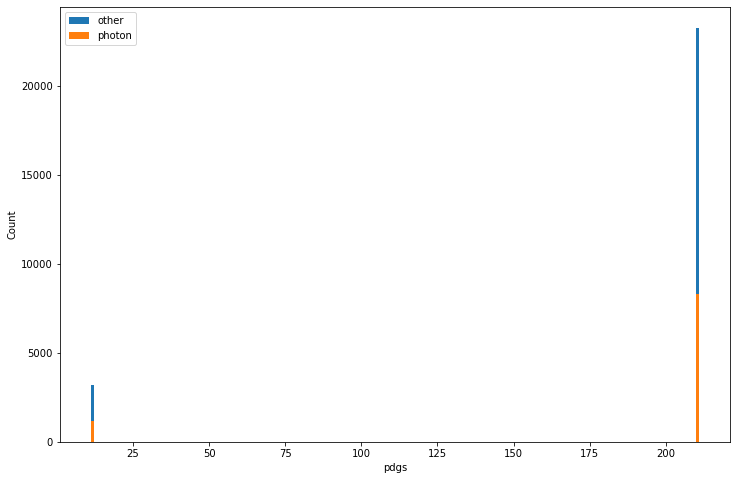

Skipped Run.
Skipped SubRun.
Skipped EventID.
Skipped totalEvents.
Skipped beamEvents.


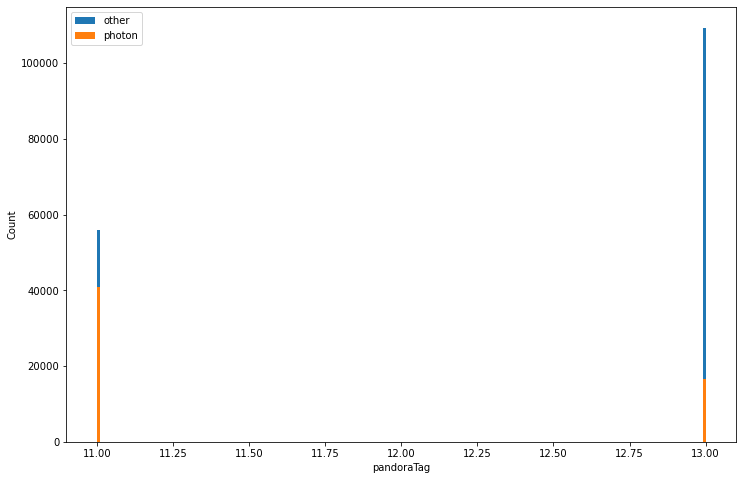

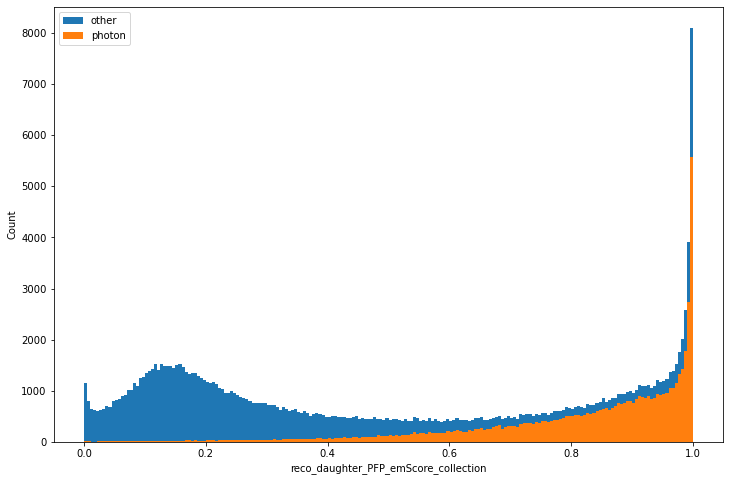

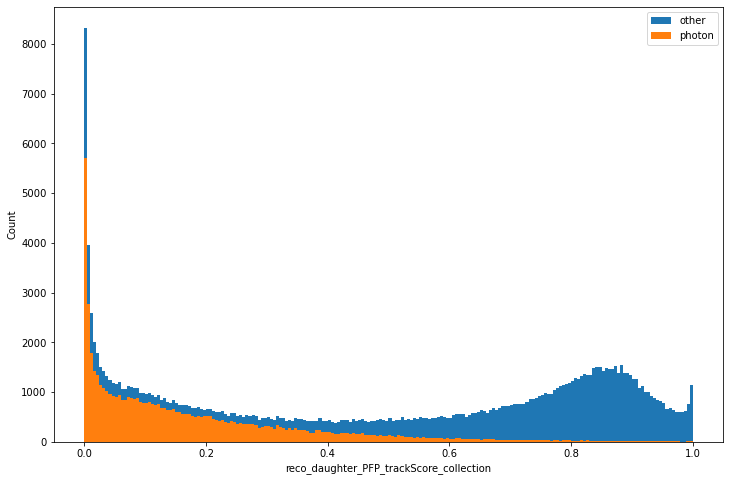

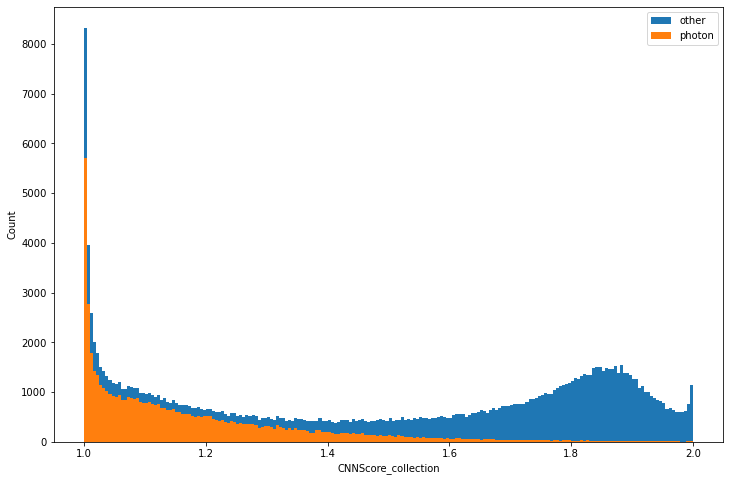

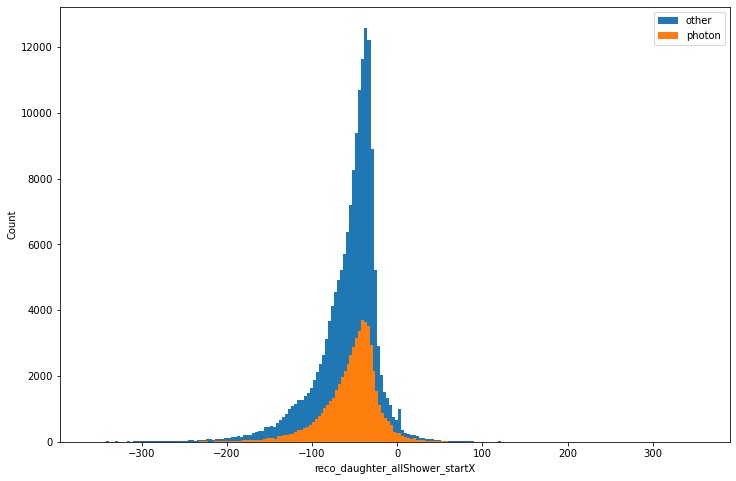

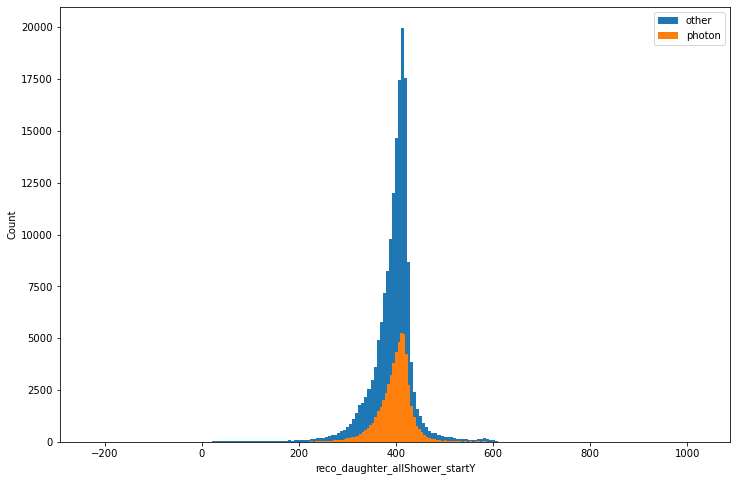

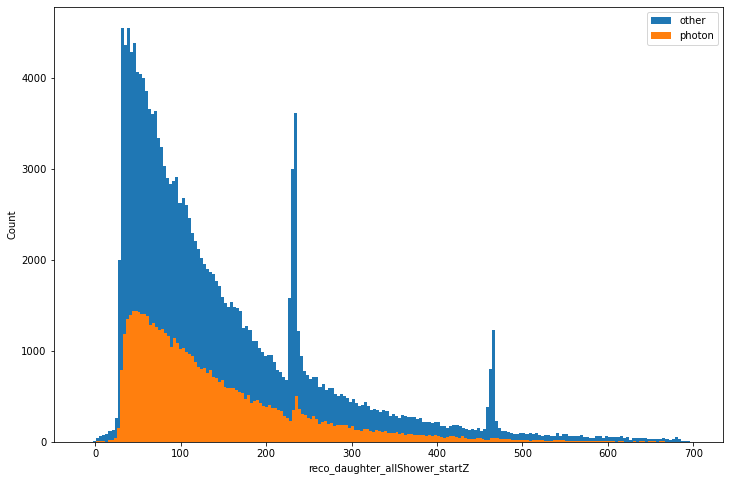

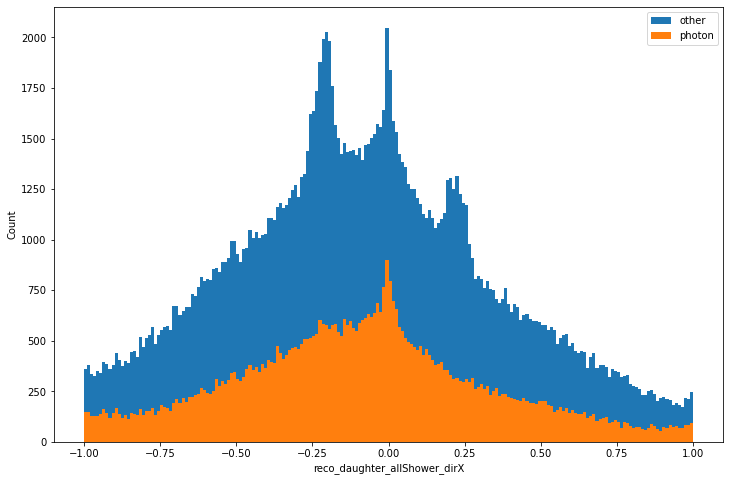

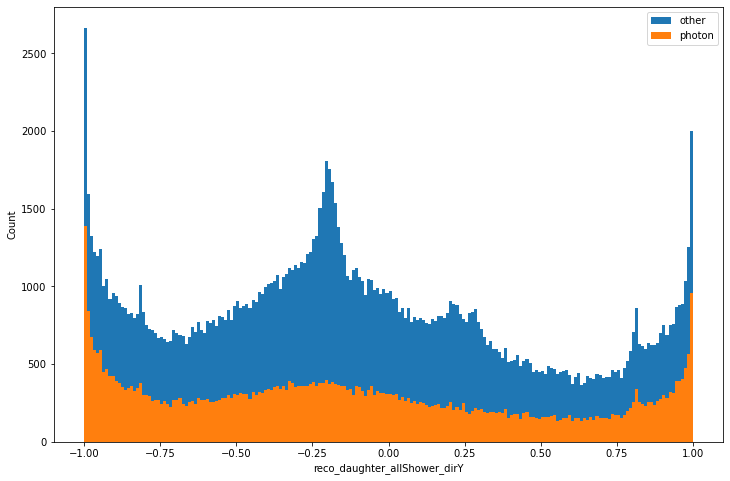

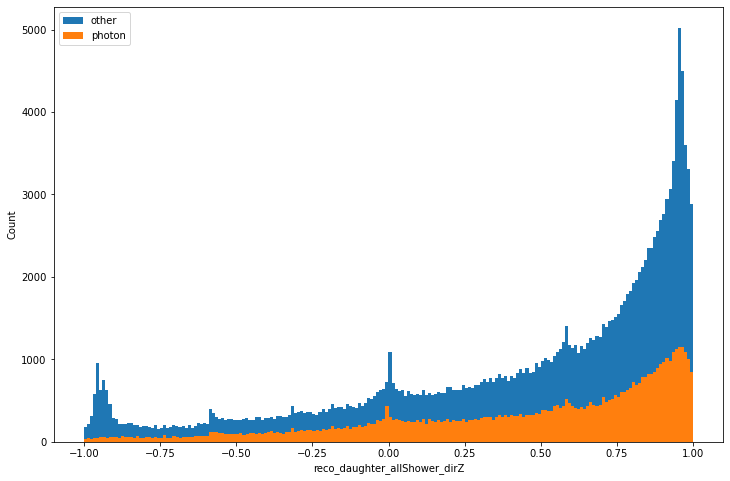

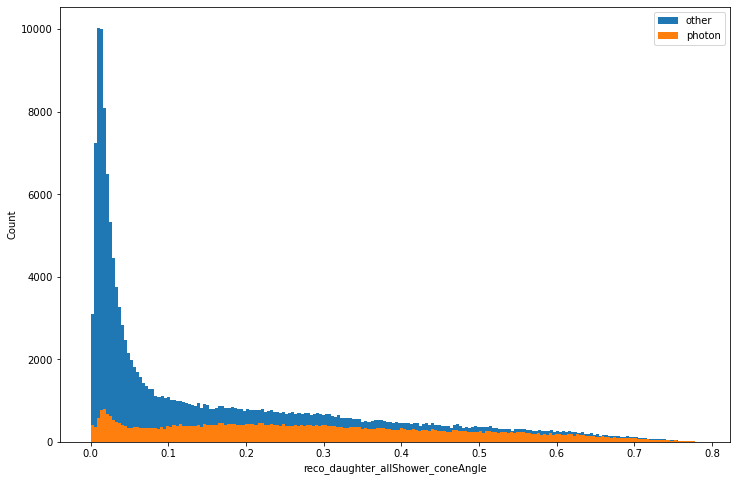

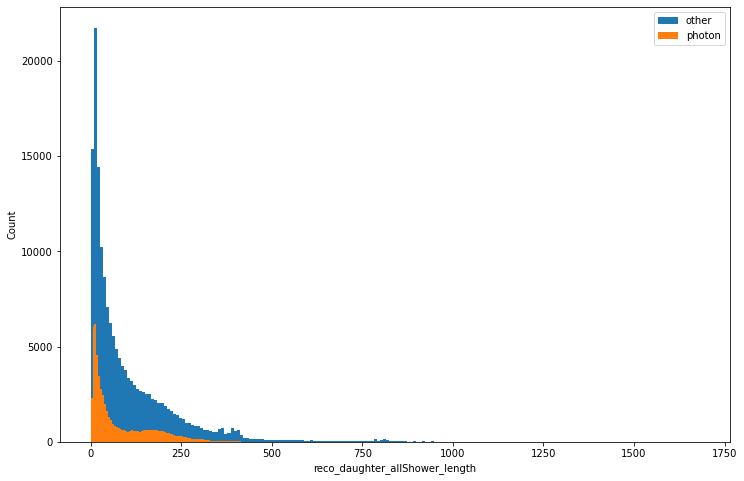

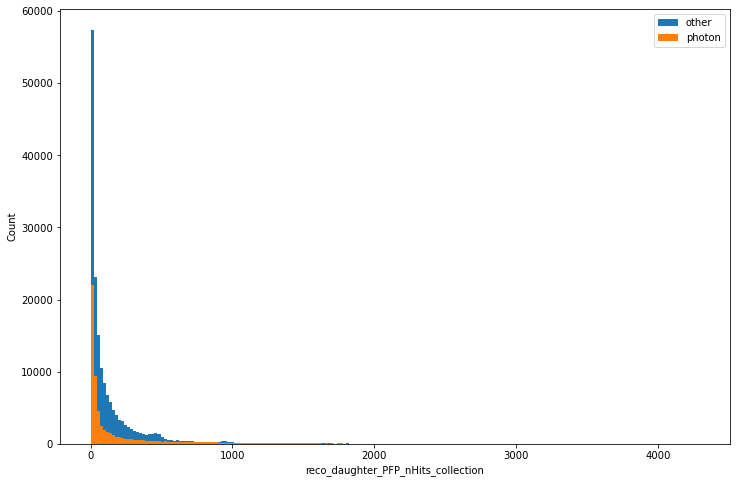

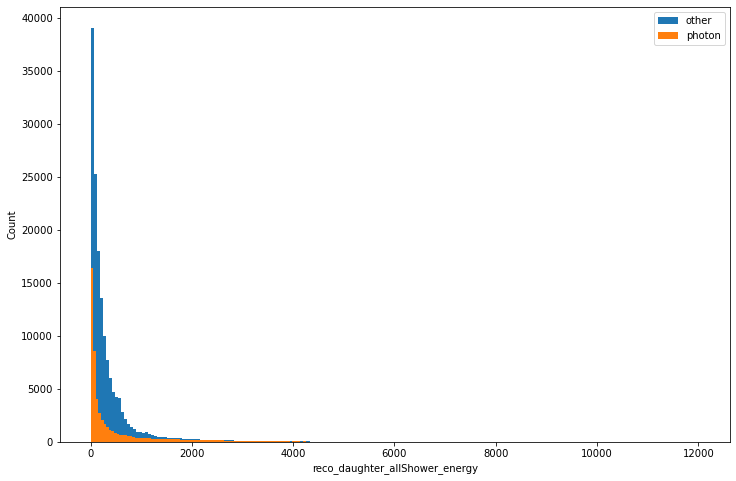

Skipped hitRadial.
Skipped hitLongitudinal.
Skipped reco_beam_startX.
Skipped reco_beam_startY.
Skipped reco_beam_startZ.
Skipped reco_beam_endX.
Skipped reco_beam_endY.
Skipped reco_beam_endZ.


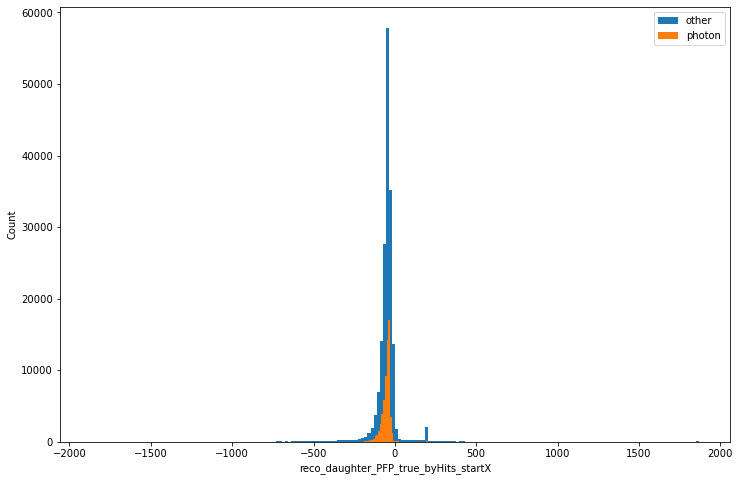

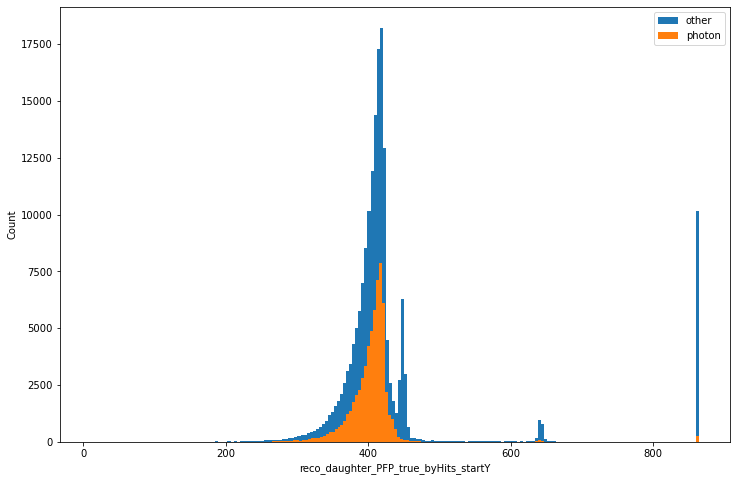

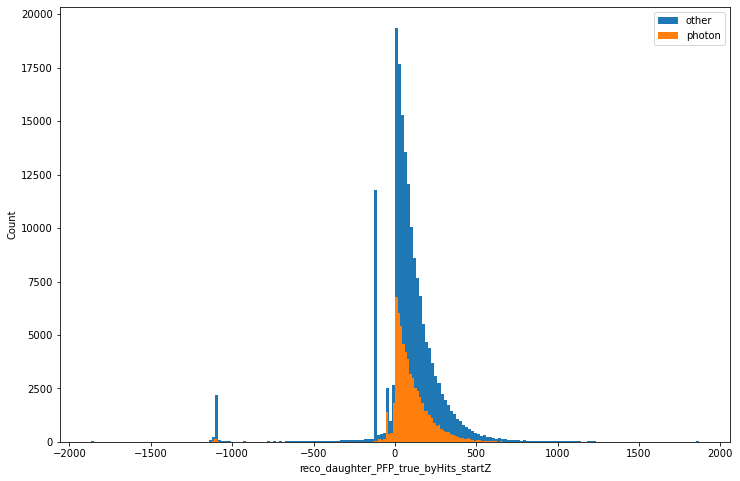

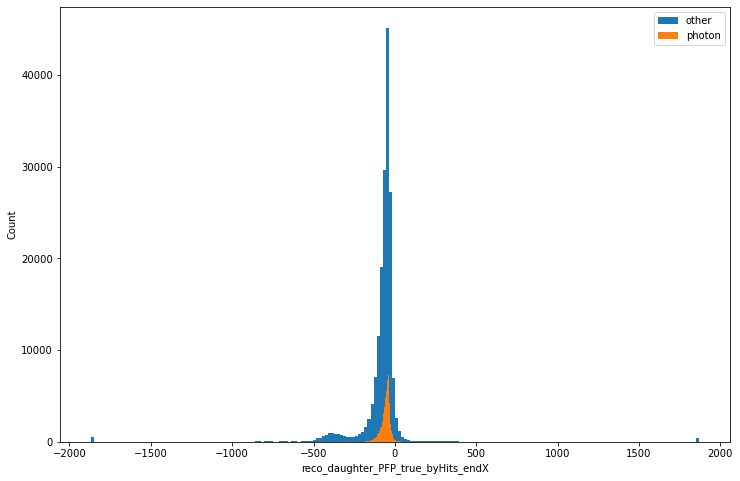

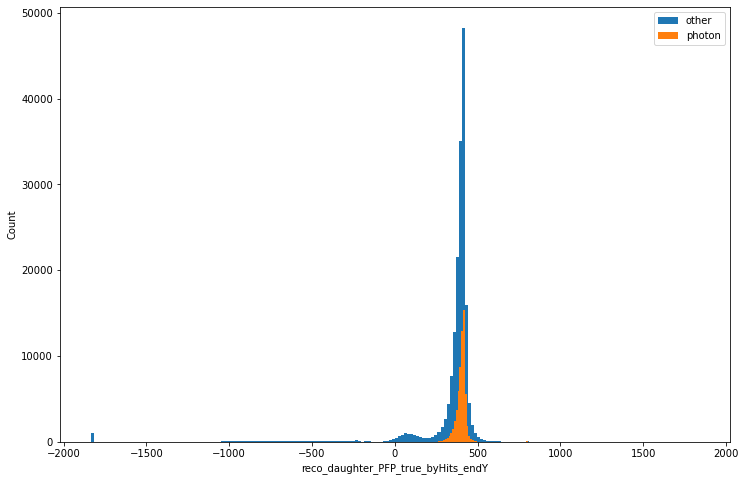

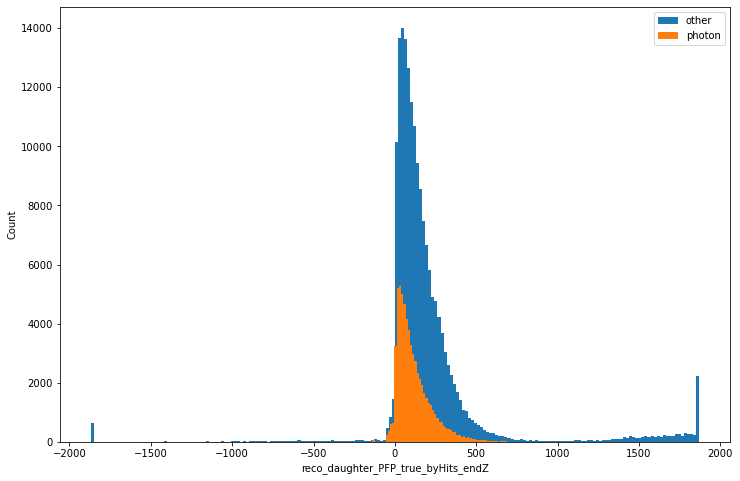

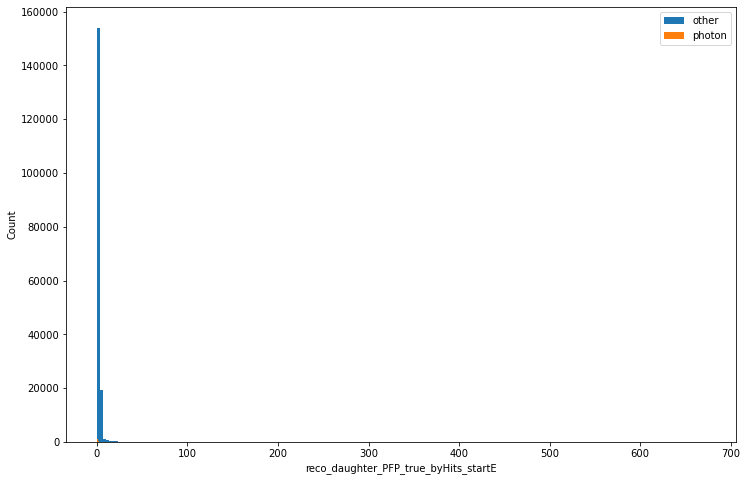

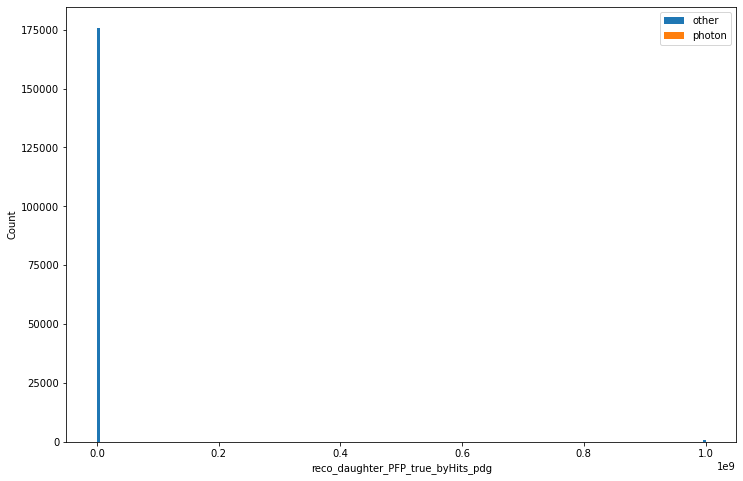

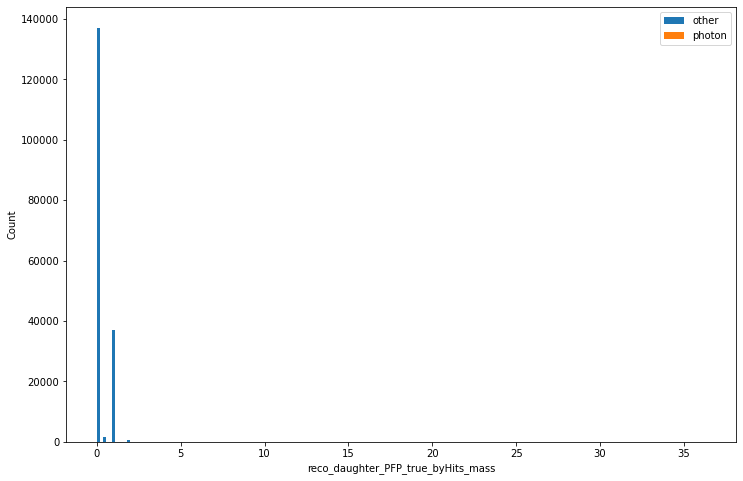

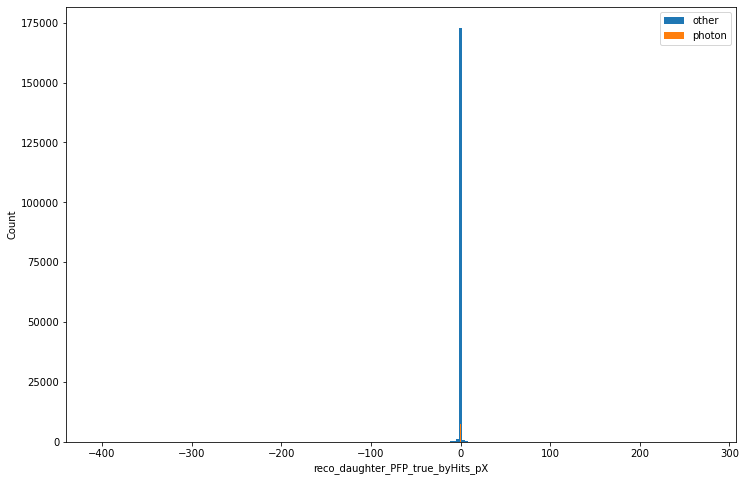

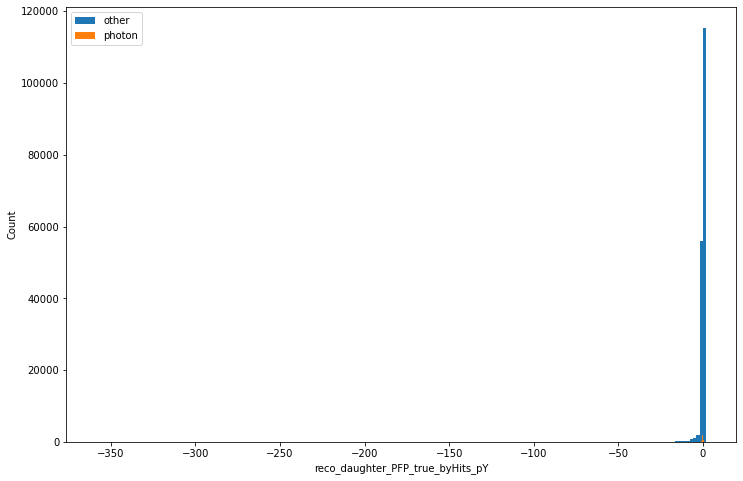

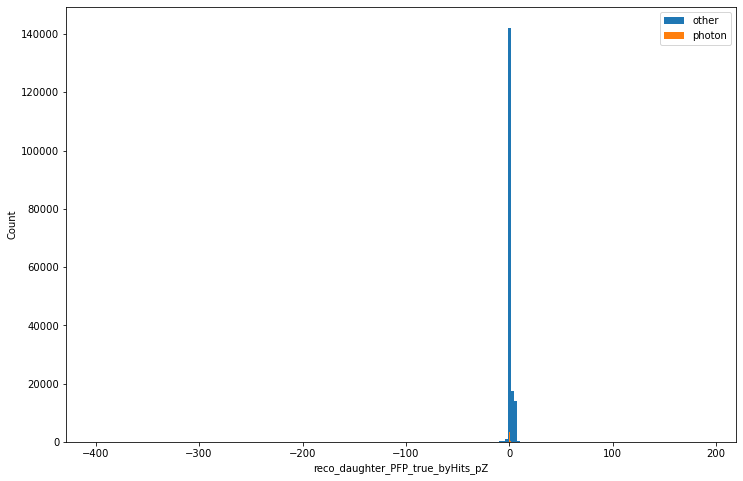

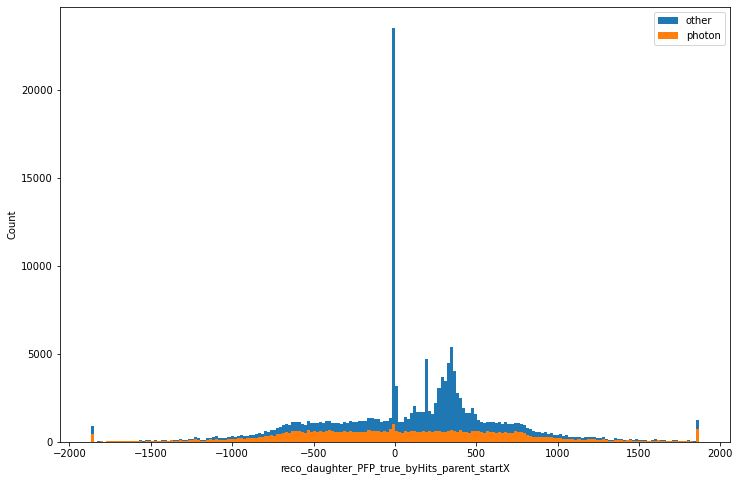

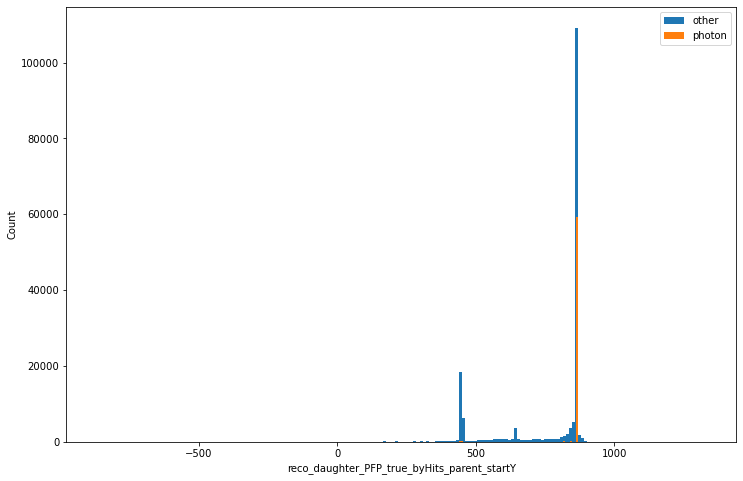

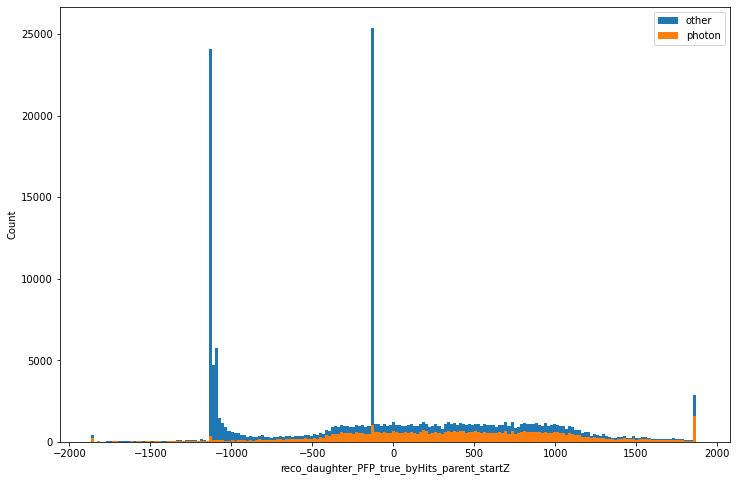

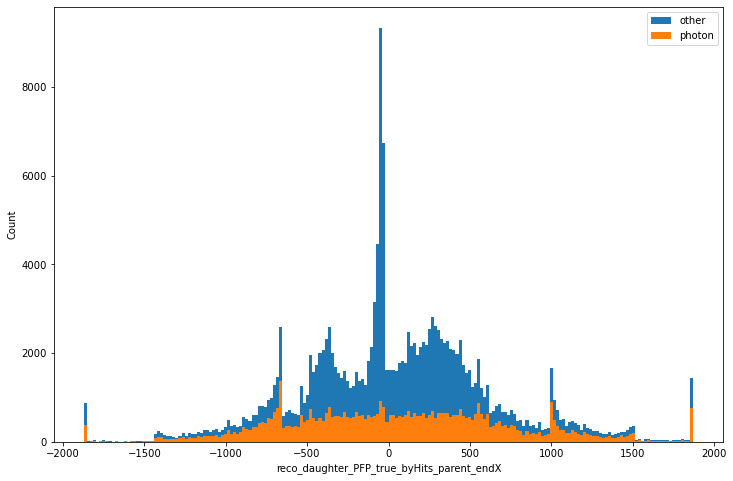

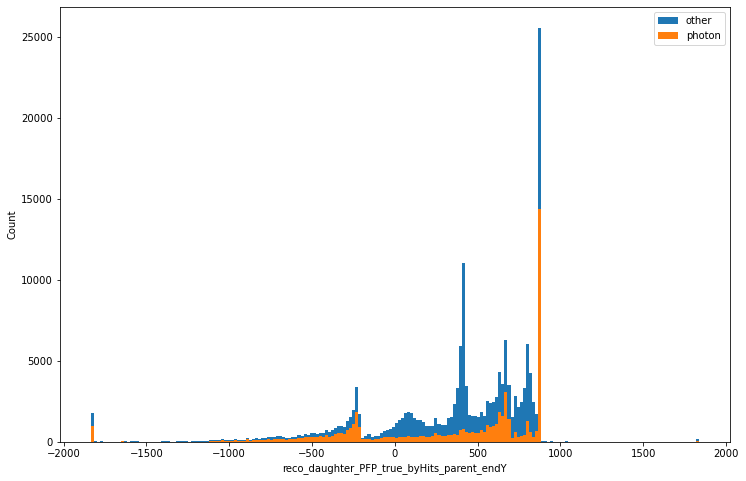

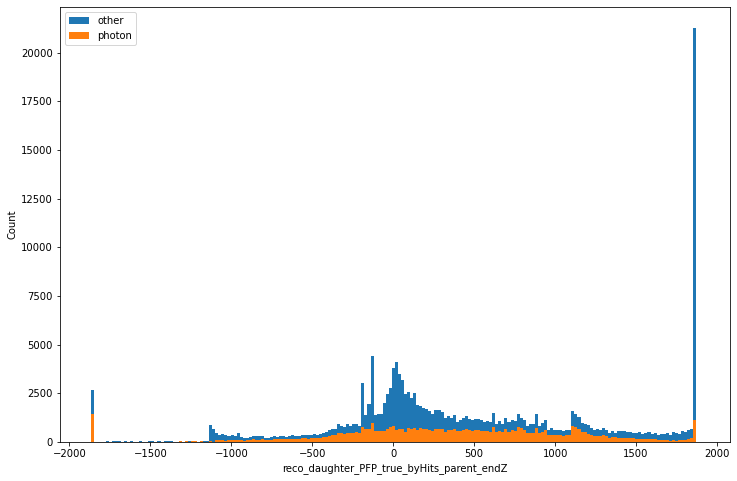

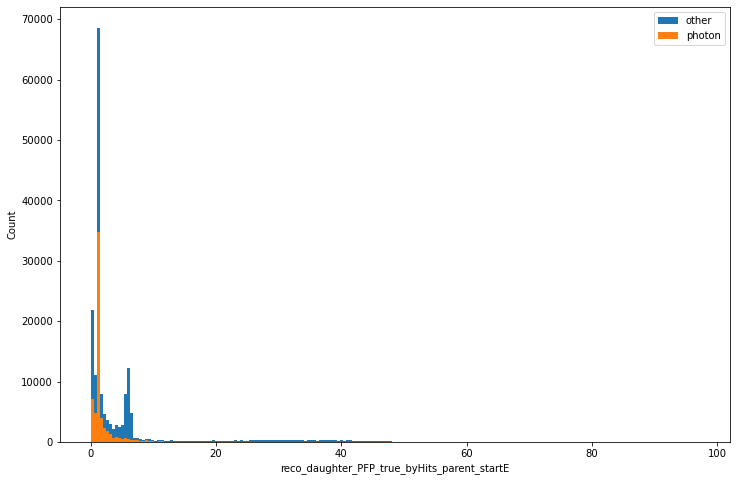

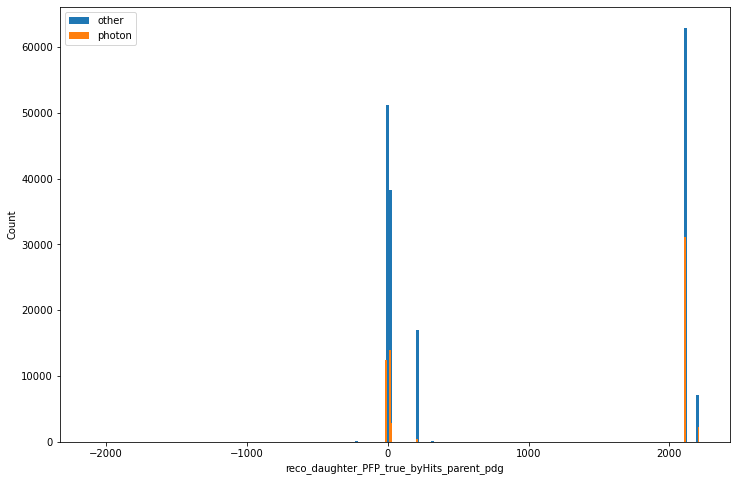

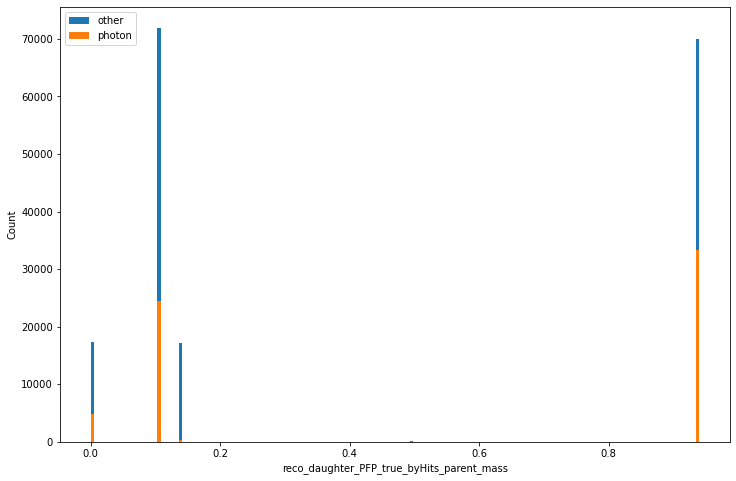

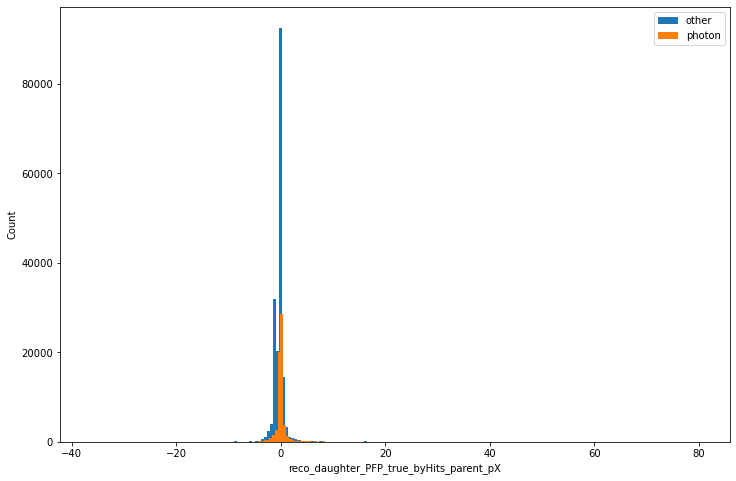

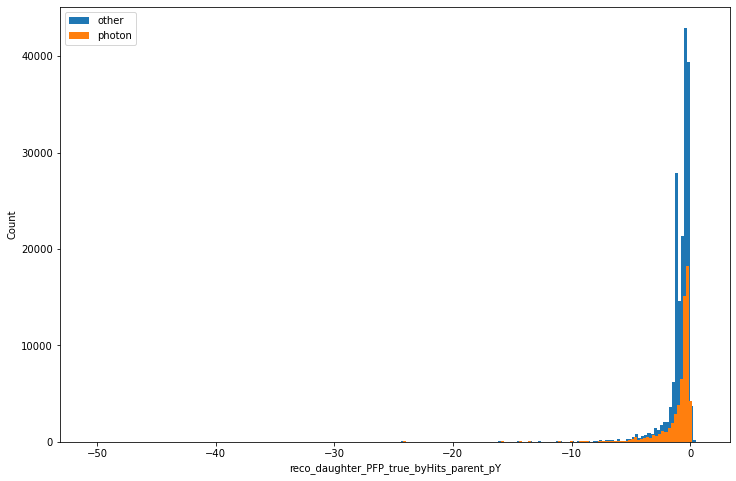

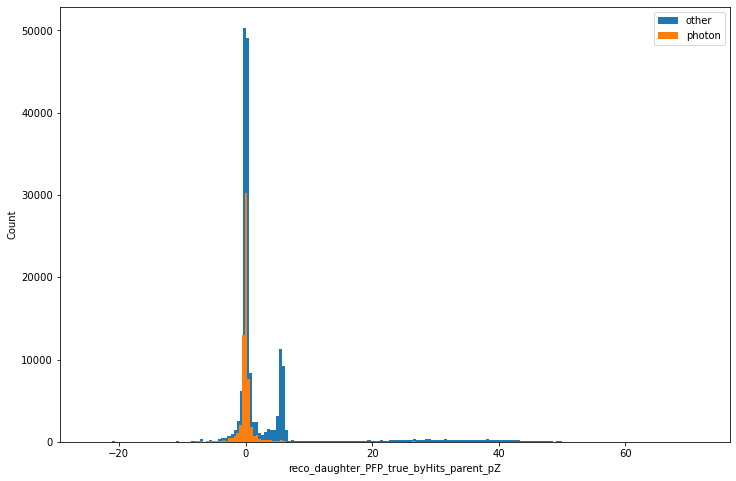

Skipped reco_beam_PFP_true_byHits_startX.
Skipped reco_beam_PFP_true_byHits_startY.
Skipped reco_beam_PFP_true_byHits_startZ.
Skipped reco_beam_PFP_true_byHits_endX.
Skipped reco_beam_PFP_true_byHits_endY.
Skipped reco_beam_PFP_true_byHits_endZ.
Skipped reco_beam_PFP_true_byHits_startE.
Skipped reco_beam_PFP_true_byHits_pdg.
Skipped reco_beam_PFP_true_byHits_mass.
Skipped g4_startX.
Skipped g4_startY.
Skipped g4_startZ.
Skipped g4_endX.
Skipped g4_endY.
Skipped g4_endZ.
Skipped g4_pX.
Skipped g4_pY.
Skipped g4_pZ.
Skipped g4_Pdg.
Skipped g4_startE.
Skipped g4_mass.
Skipped g4_num.
Skipped g4_mother.


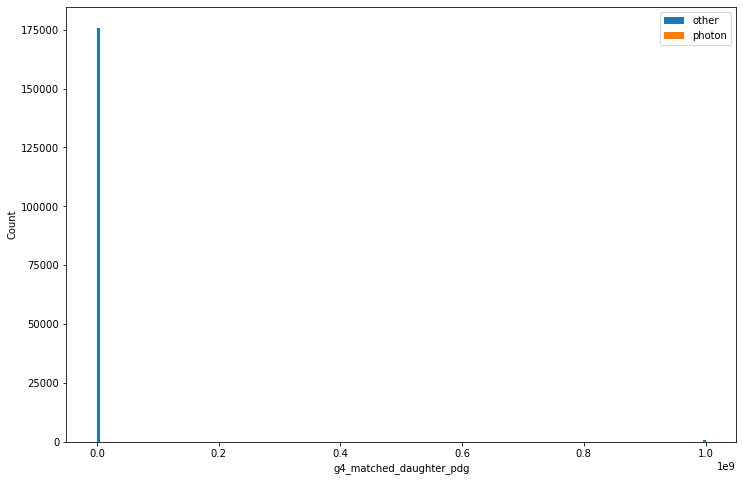

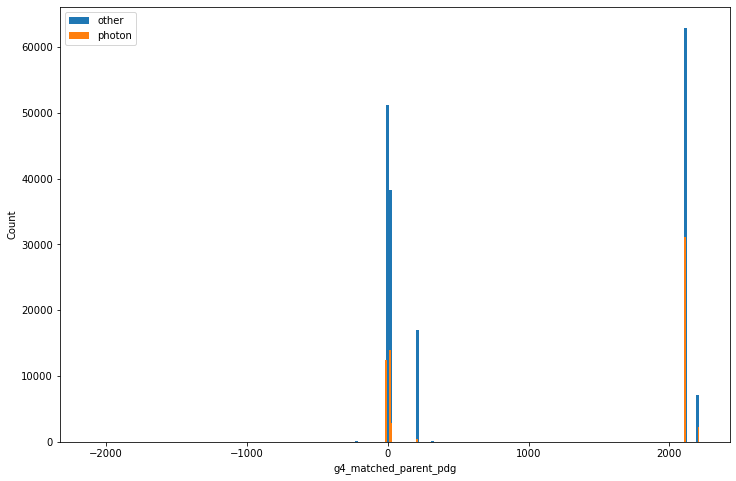

In [5]:
pdgs = ak.flatten(events.trueParticlesBT.pdg)
print(np.unique(pdgs.to_numpy()))
# test_shape = ak.num(events.trueParticlesBT.GetValues("g4_mass"), axis=1)
for key in events.io.List():
    try:
        data = ak.flatten(events.recoParticles.GetValues(key))
        plotStackedHistSimple(data[data != -999], pdgs[data != -999], key)
    except:
        print(f"Skipped {key}.")
        plt.close()

In [6]:
# This cell looks at the VALUES of a given parameter.
param='pandoraTag'
print(events.recoParticles.GetValues(param))
print(np.unique(ak.flatten(events.recoParticles.GetValues(param)).to_numpy(), return_counts=True))
print(len(np.unique(ak.flatten(events.recoParticles.GetValues(param)).to_numpy())))

[[13, 13, 13, 13, 13, 11, 13, 13, 13, 13], ... [11, 13, 11, 11, 13, 13, -999], []]
(array([-999,   11,   13], dtype=int32), array([ 11379,  55915, 109395]))
3


In [7]:
# This cell looks at the NUMBER of entries for a given parameter.
param='pandoraTag'
depths = ak.num(events.trueParticlesBT.GetValues(param), axis=1)
print(depths)
print(np.unique(depths, return_counts=True))
print(len(np.unique(depths)))

[10, 0, 2, 0, 7, 10, 4, 1, 0, 3, 9, 3, 0, ... 5, 0, 1, 0, 15, 0, 4, 0, 0, 9, 0, 7, 0]
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 30]), array([14316,  1090,  1621,  2312,  2687,  2751,  2813,  2835,  2553,
        2131,  1667,  1221,   868,   593,   403,   233,   152,    89,
          58,    45,    20,    14,     9,     9,     2,     3,     2,
           3,     1]))
29


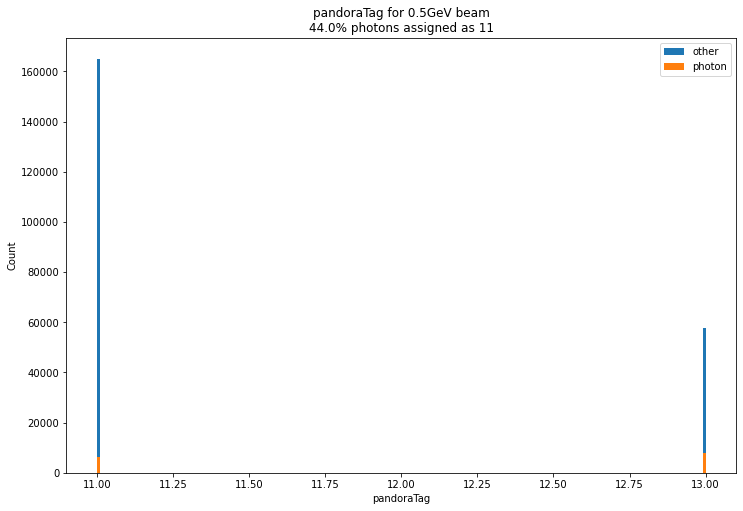

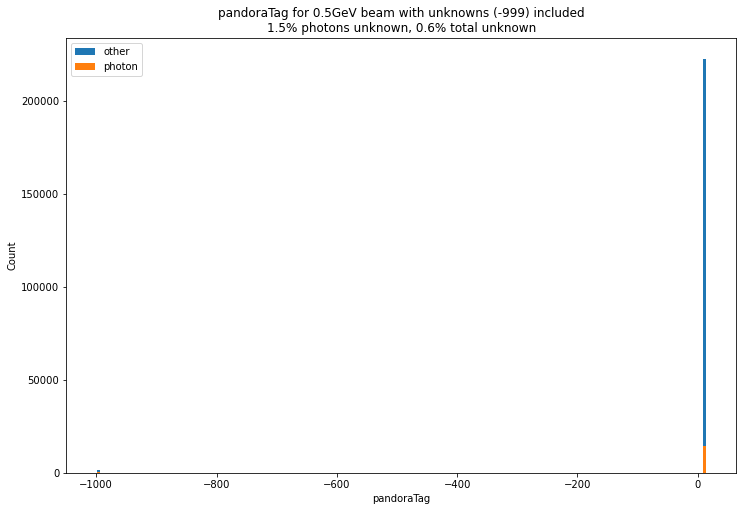

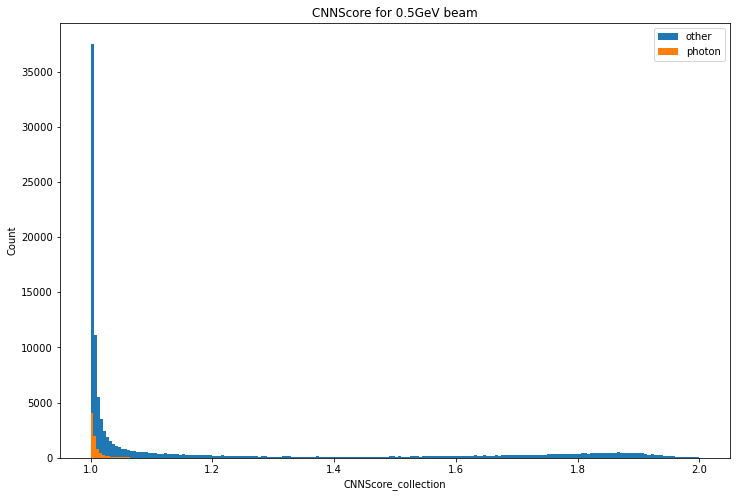

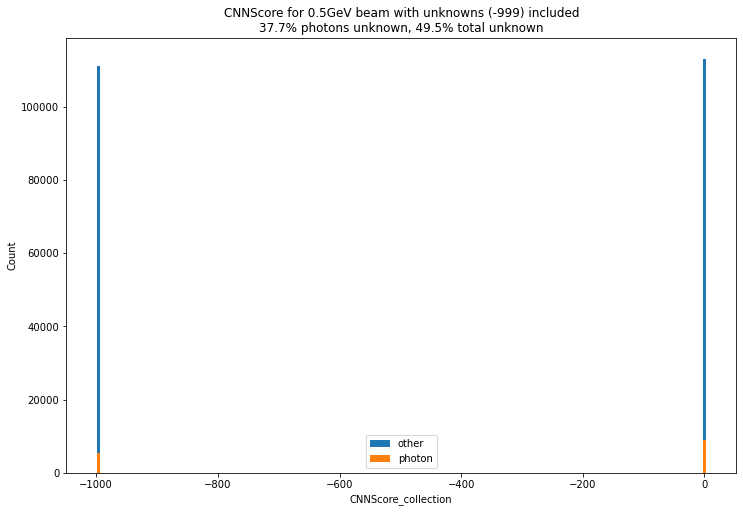

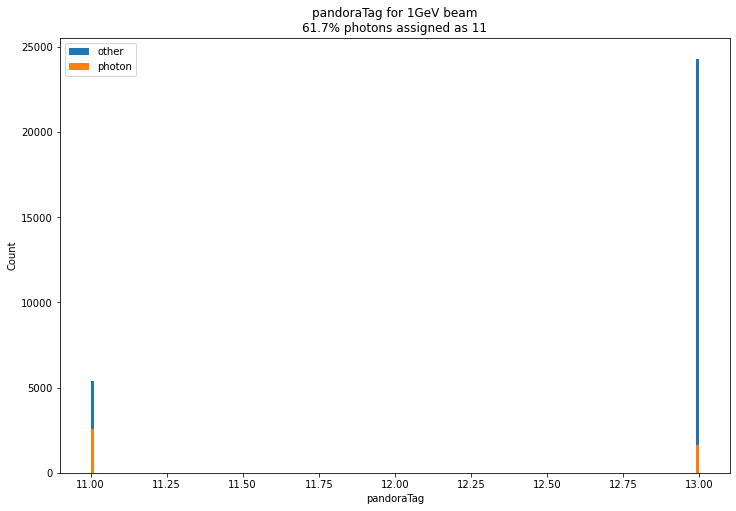

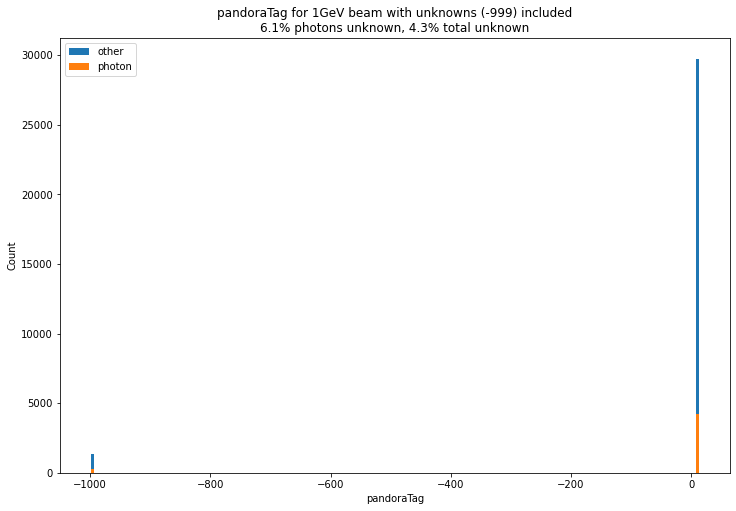

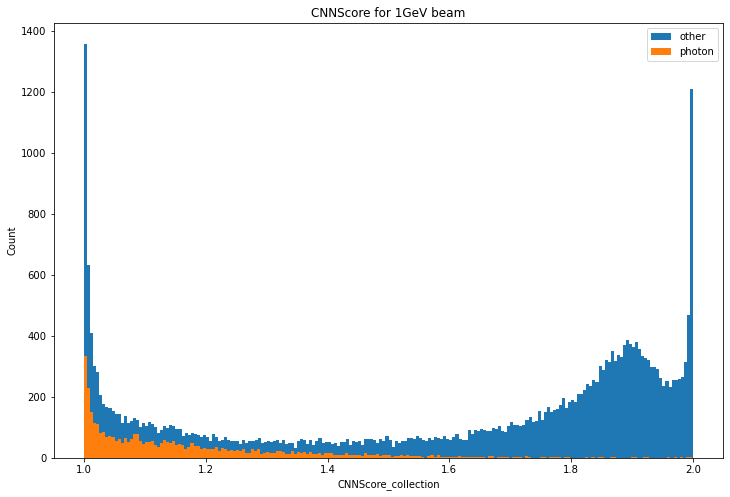

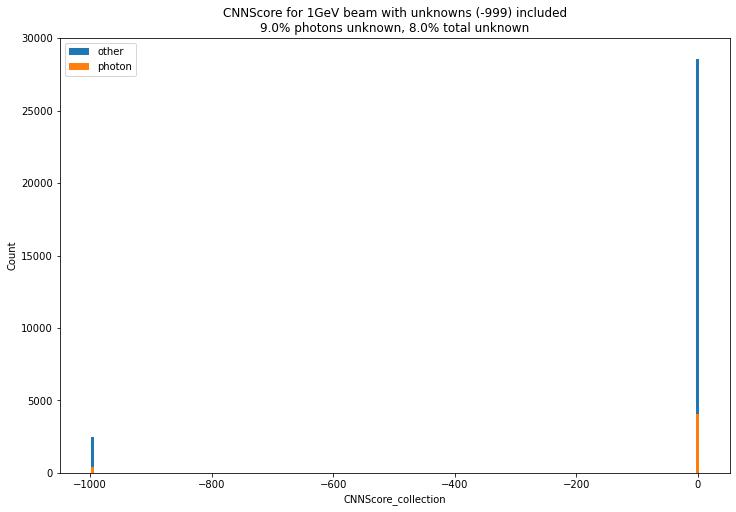

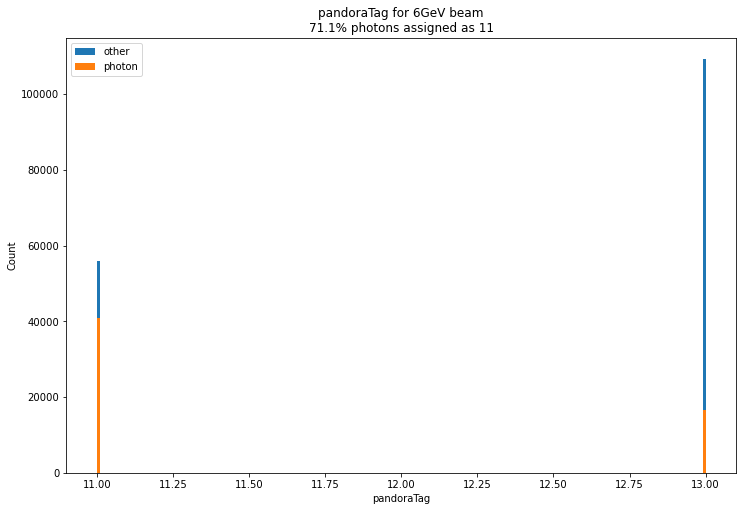

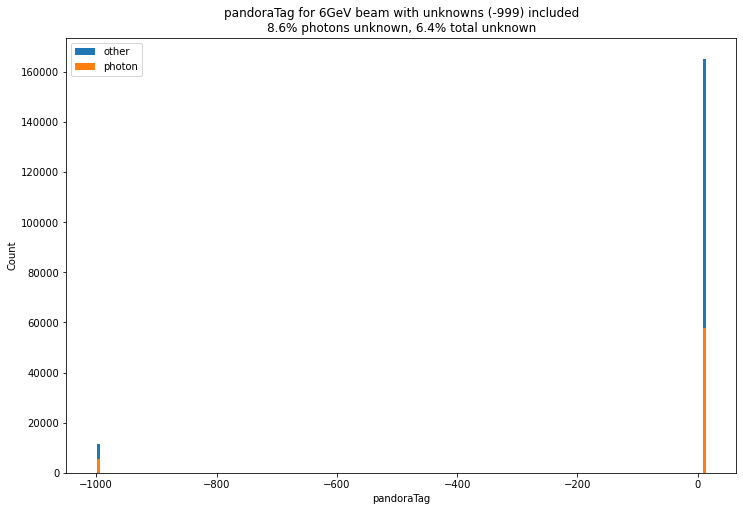

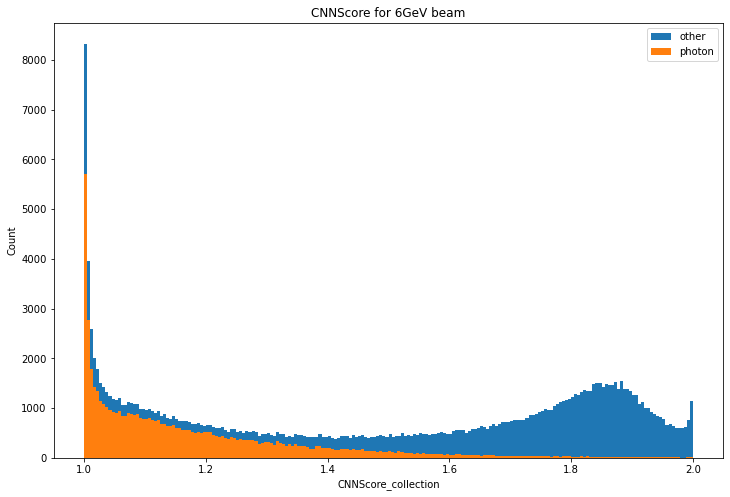

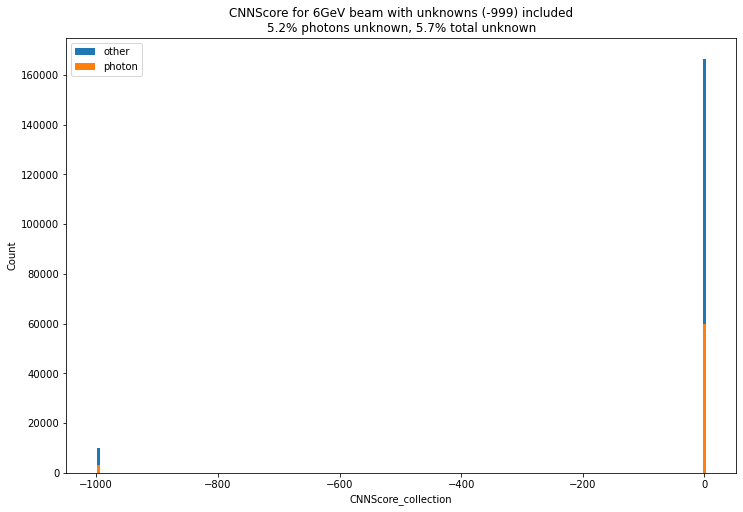

In [24]:
# pdgs = ak.flatten(events.trueParticlesBT.pdg)
# print(np.unique(pdgs.to_numpy()))

params_to_use = ["pandoraTag", "CNNScore_collection"]

for energy in beamData.keys():
    evts = beamData[energy]
    pdgs = ak.flatten(evts.trueParticlesBT.pdg)

    plotParameterDistribution(ak.flatten(evts.recoParticles.pandoraTag), pdgs, f"pandoraTag for {energy}GeV beam", "pandoraTag")
    plotParameterDistribution(ak.flatten(evts.recoParticles.cnnScore), pdgs, f"CNNScore for {energy}GeV beam", "CNNScore_collection")

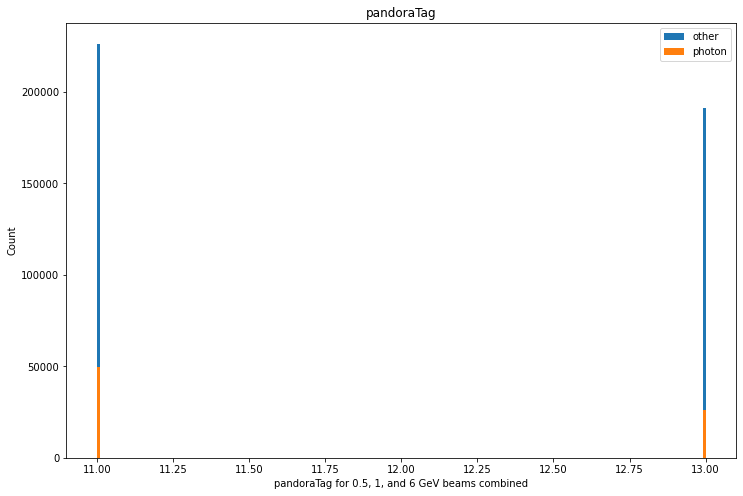

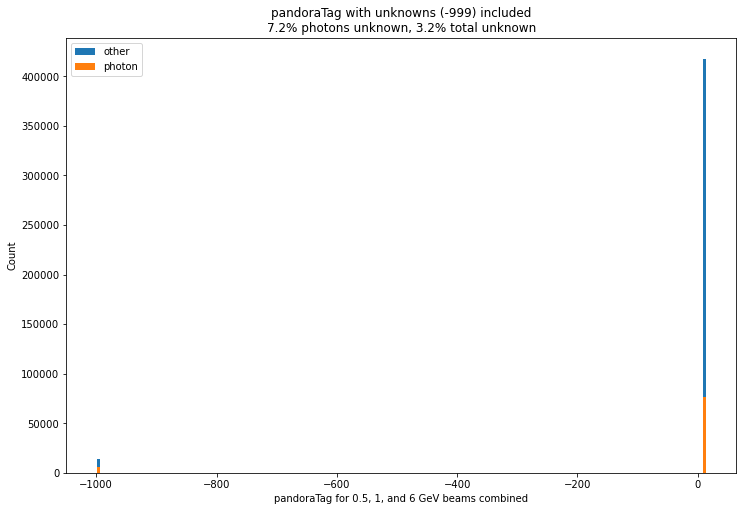

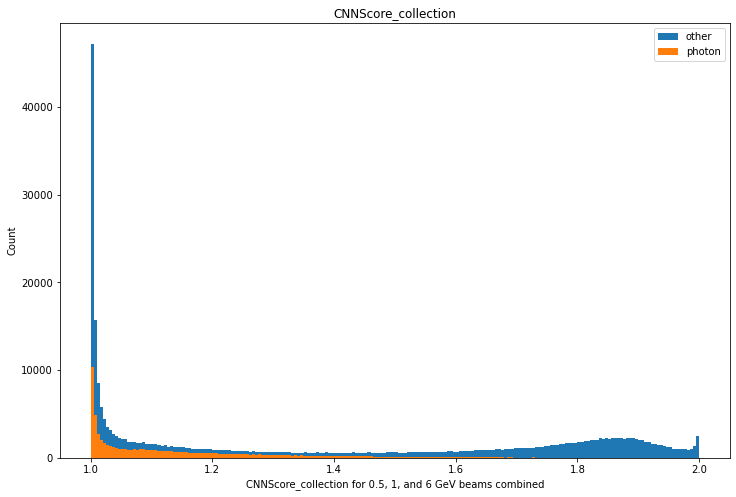

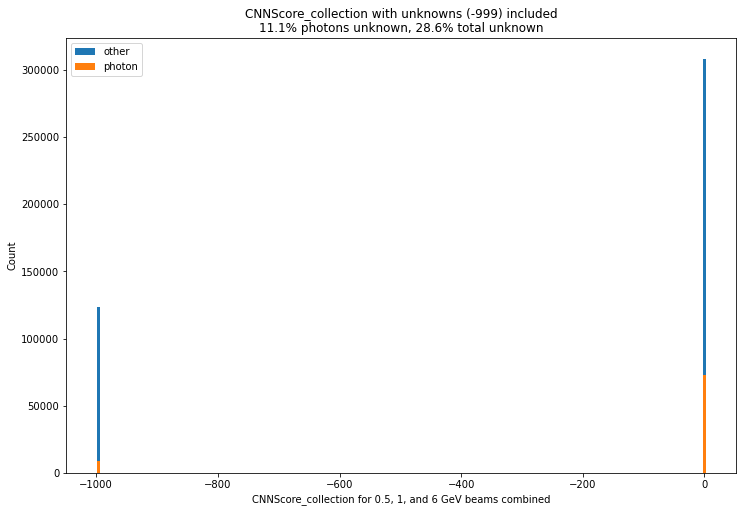

In [16]:
for key in params_to_use:
    sum_data = ak.concatenate([ak.flatten(evts.recoParticles.GetValues(key)) for evts in beamData.values()])
    sum_pdgs = ak.concatenate([ak.flatten(evts.trueParticlesBT.pdg) for evts in beamData.values()])

    plotParameterDistribution(sum_data, sum_pdgs, key, f"{key} for 0.5, 1, and 6 GeV beams combined")

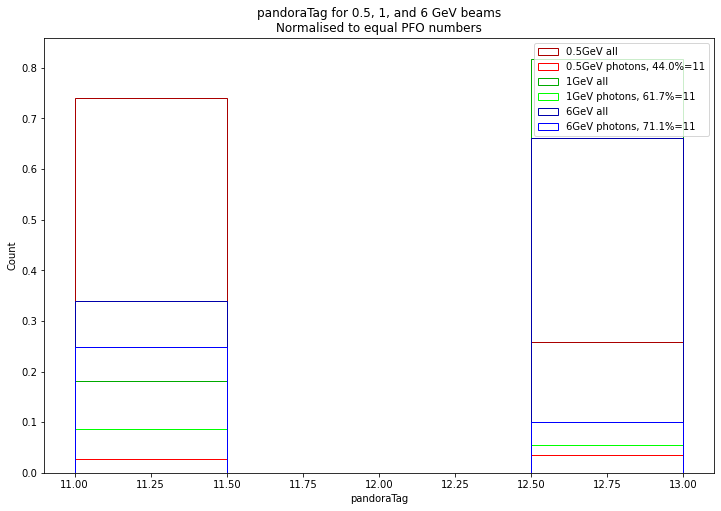

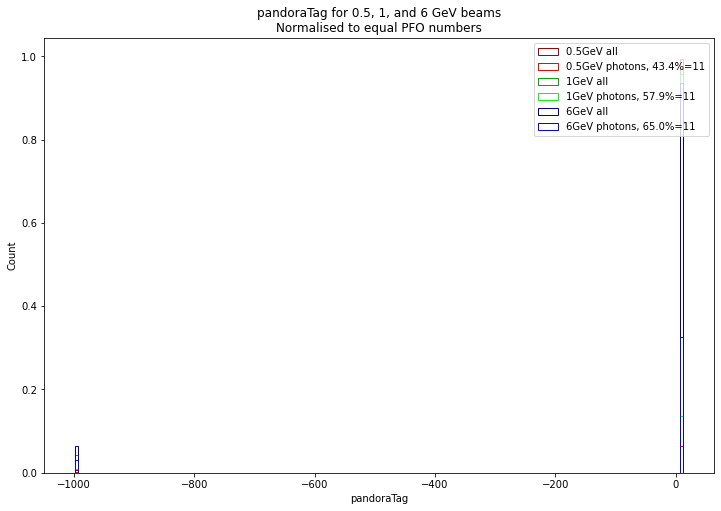

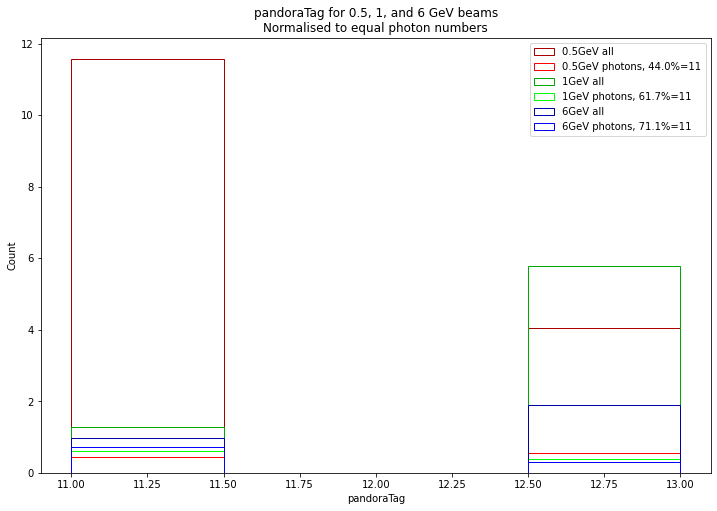

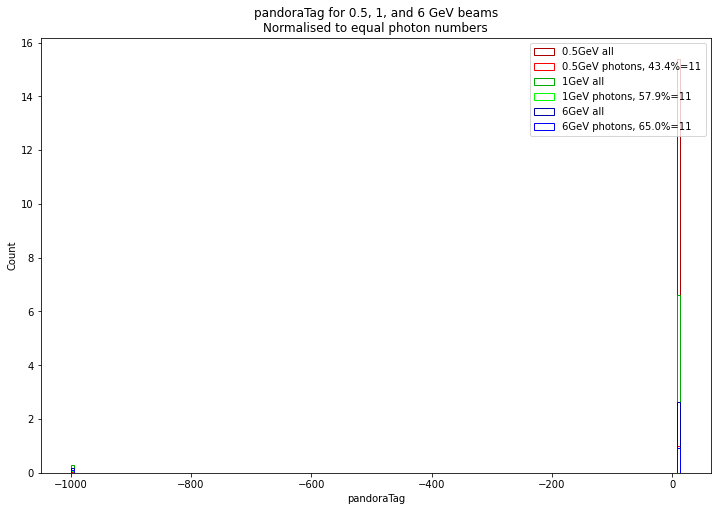

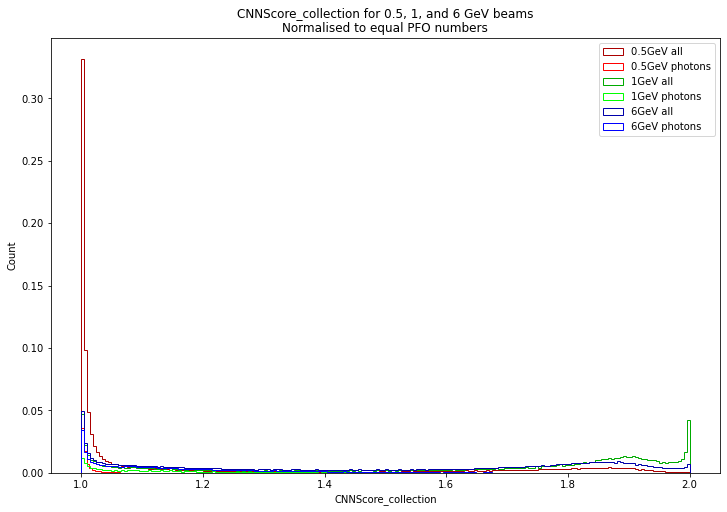

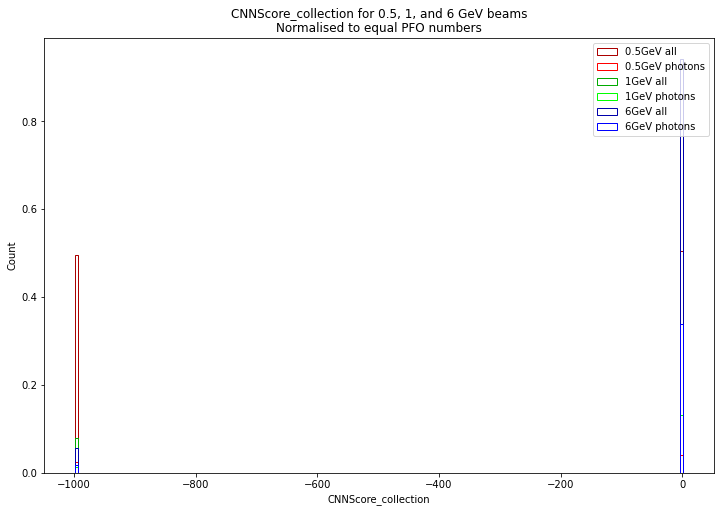

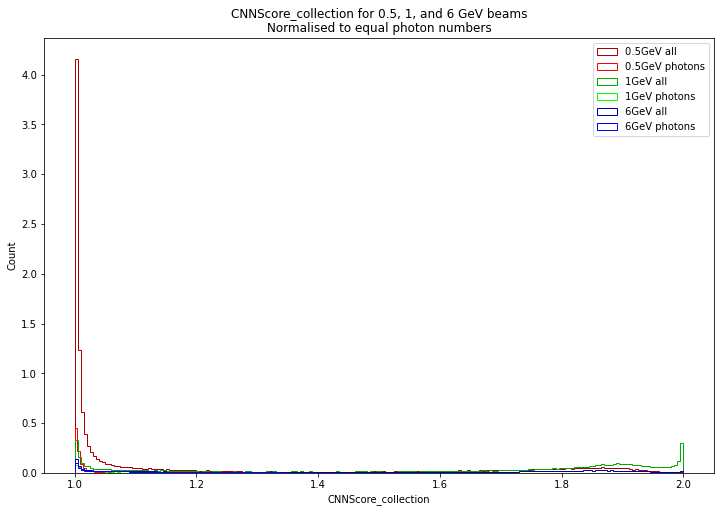

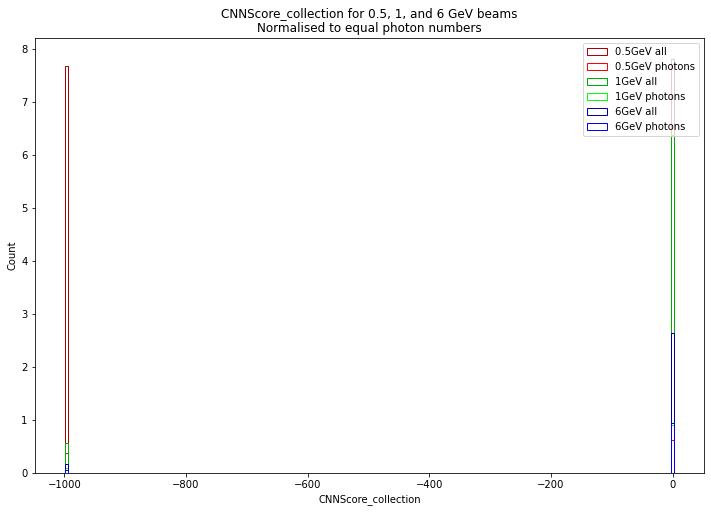

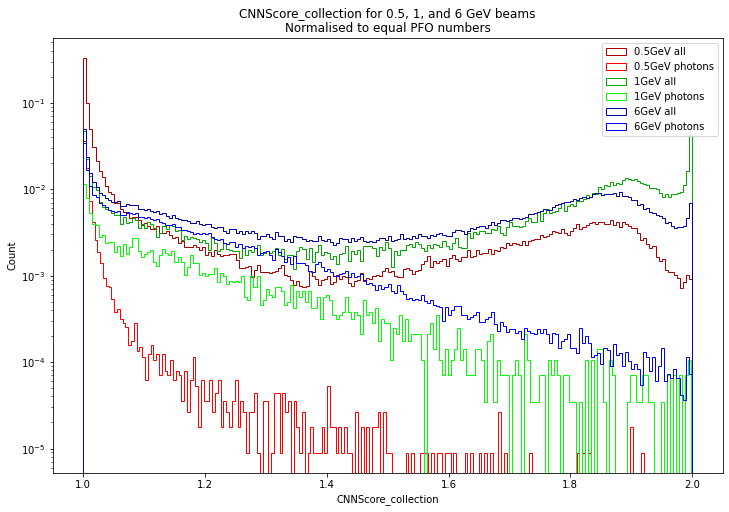

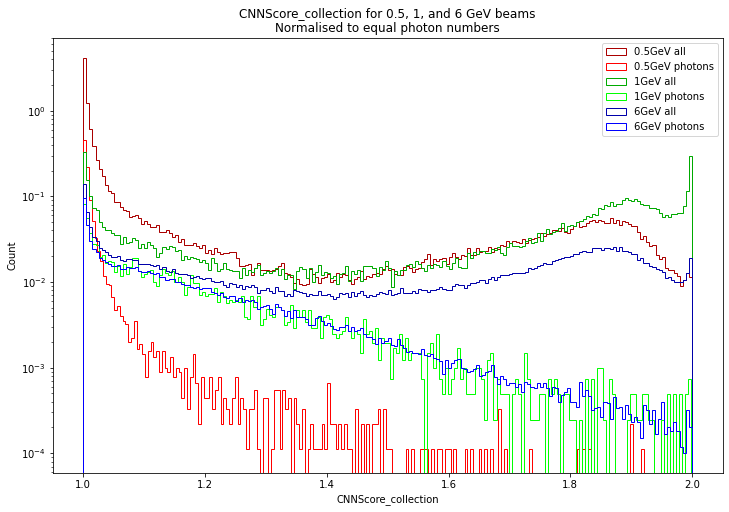

In [21]:
colour_scheme_photons = {
    0.5:"#ff0000",
    1:  "#00ff00",
    6:  "#0000ff",
}
colour_scheme_all = {
    0.5:"#aa0000",
    1:  "#00aa00",
    6:  "#0000aa",
}
for key in params_to_use:
    plotMultiBeamDistribution(beamData, key, unknowns = False, normalise = 'all',  particle = 22, colours_all = colour_scheme_all, colours_particle = colour_scheme_photons, log = False)
    plotMultiBeamDistribution(beamData, key, unknowns = True,  normalise = 'all',  particle = 22, colours_all = colour_scheme_all, colours_particle = colour_scheme_photons, log = False)
    plotMultiBeamDistribution(beamData, key, unknowns = False, normalise = 'photon',  particle = 22, colours_all = colour_scheme_all, colours_particle = colour_scheme_photons, log = False)
    plotMultiBeamDistribution(beamData, key, unknowns = True,  normalise = 'photon',  particle = 22, colours_all = colour_scheme_all, colours_particle = colour_scheme_photons, log = False)
    if key == "CNNScore_collection":
        plotMultiBeamDistribution(beamData, key, unknowns = False, normalise = 'all',  particle = 22, colours_all = colour_scheme_all, colours_particle = colour_scheme_photons, log = True)
        plotMultiBeamDistribution(beamData, key, unknowns = False, normalise = 'photon',  particle = 22, colours_all = colour_scheme_all, colours_particle = colour_scheme_photons, log = True)

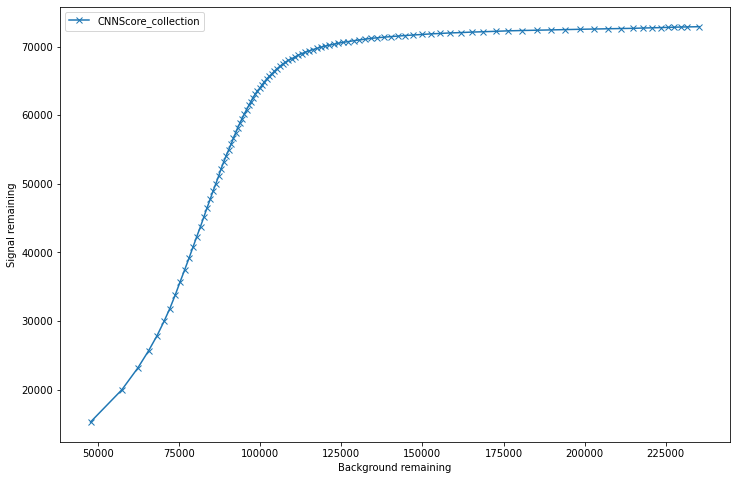

In [21]:
rocCurve(
    ak.concatenate([ak.flatten(evts.recoParticles.GetValues("CNNScore_collection")) for evts in beamData.values()]),
    ak.concatenate([ak.flatten(evts.trueParticlesBT.pdg) for evts in beamData.values()]),
    particle = 22, labels="CNNScore_collection", cut_high=True
)
# TODO plot with pandora tag 11 and 13 separately
# - add point demonstrationg efficient/bkg cut with pandora tag
# - make version with no mornalisation
# Next step calculate mass of each possible pairing, compare with true/reco pi0 mass

In [8]:
new_data = Master.Data("/scratch/wx21978/pi0/root_files/6GeV_beam_v1/Prod4a_6GeV_BeamSim_00.root", includeBackTrackedMC=True)
new_data_name = "6GeV_beam_v1/Prod4a_6GeV_BeamSim_00.root"

In [9]:
cnn_score = ak.flatten(new_data.recoParticles.cnnScore)
pandora_tag = ak.flatten(new_data.recoParticles.pandoraTag)
pdg_vals_all = ak.flatten(new_data.trueParticlesBT.pdg)

print("Invalid CNN scores before quality cuts: {}".format(sum(cnn_score==-999)))
print("Invalid pandora tags before quality cuts: {}".format(sum(pandora_tag==-999)))
print("Invalid pandora tag OR CNN score before quality cuts: {}".format(sum(np.logical_or(cnn_score==-999, pandora_tag==-999))))
print("Invalid pandora tag AND CNN score before quality cuts: {}".format(sum(np.logical_and(cnn_score==-999, pandora_tag==-999))))

# new_data_quality = new_data
# new_data_quality = new_data_quality.ApplyBeamFilter()
# new_data_quality = new_data_quality.Filter([new_data_quality.recoParticles.nHits > 50], [])

new_data.ApplyBeamFilter()

cnn_score = ak.flatten(new_data.recoParticles.cnnScore)
pandora_tag = ak.flatten(new_data.recoParticles.pandoraTag)
pdg_vals_beam = ak.flatten(new_data.trueParticlesBT.pdg)
print("Invalid CNN scores before nHits cut: {}".format(sum(cnn_score==-999)))
print("Invalid pandora tags before nHits cut: {}".format(sum(pandora_tag==-999)))
print("Invalid pandora tag OR CNN score before nHits cut: {}".format(sum(np.logical_or(cnn_score==-999, pandora_tag==-999))))
print("Invalid pandora tag AND CNN score before nHits cut: {}".format(sum(np.logical_and(cnn_score==-999, pandora_tag==-999))))

new_data.Filter([new_data.recoParticles.nHits > 50], [])

cnn_score = ak.flatten(new_data.recoParticles.cnnScore)
pandora_tag = ak.flatten(new_data.recoParticles.pandoraTag)
pdg_vals = ak.flatten(new_data.trueParticlesBT.pdg)

print("Invalid CNN scores after quality cuts: {}".format(sum(cnn_score==-999)))
print("Invalid pandora tags after quality cuts: {}".format(sum(pandora_tag==-999)))
print("Invalid pandora tag OR CNN score after quality cuts: {}".format(sum(np.logical_or(cnn_score==-999, pandora_tag==-999))))
print("Invalid pandora tag AND CNN score after quality cuts: {}".format(sum(np.logical_and(cnn_score==-999, pandora_tag==-999))))

# pandora_tag = pandora_tag_all[cnn_score_all!=-999]
# pdg_vals = pdg_vals_all[cnn_score_all!=-999]
# cnn_score = cnn_score_all[cnn_score_all!=-999]

total_sig_all = sum(pdg_vals_all==22)
total_bkg_all = sum(pdg_vals_all!=22)
total_sig_beam = sum(pdg_vals_beam==22)
total_bkg_beam = sum(pdg_vals_beam!=22)
total_sig = sum(pdg_vals==22)
total_bkg = sum(pdg_vals!=22)

print(f"Total: {total_sig_all} photons, {total_bkg_all} other. Beam: {total_sig_beam} photons, {total_bkg_beam} other. Quality: {total_sig} photons, {total_bkg} other.")

Invalid CNN scores before quality cuts: 30687478
Invalid pandora tags before quality cuts: 769056
Invalid pandora tag OR CNN score before quality cuts: 31409547
Invalid pandora tag AND CNN score before quality cuts: 46987
'ApplyBeamFilter' executed in 36.0483s
Invalid CNN scores before nHits cut: 23524
Invalid pandora tags before nHits cut: 23532
Invalid pandora tag OR CNN score before nHits cut: 43683
Invalid pandora tag AND CNN score before nHits cut: 3373
Invalid CNN scores after quality cuts: 0
Invalid pandora tags after quality cuts: 167
Invalid pandora tag OR CNN score after quality cuts: 167
Invalid pandora tag AND CNN score after quality cuts: 0
Total: 12926269 photons, 52061708 other. Beam: 139826 photons, 309603 other. Quality: 67281 photons, 179215 other.


In [10]:
# new_data.ApplyBeamFilter()
# new_data.Filter([new_data.recoParticles.nHits > 50], [])

# cnn_score = ak.flatten(new_data.recoParticles.cnnScore)
# pandora_tag = ak.flatten(new_data.recoParticles.pandoraTag)
# pdg_vals = ak.flatten(new_data.trueParticlesBT.pdg)

# total_sig = sum(pdg_vals==22)
# total_bkg = sum(pdg_vals!=22)

/users/wx21978/projects/pion-phys/pi0-analysis/notebooks/../analysis/Master.py:45: UserWarning: Couldn't apply filters to beam_number.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/notebooks/../analysis/Master.py:45: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/notebooks/../analysis/Master.py:45: UserWarning: Couldn't apply filters to eventNum.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/notebooks/../analysis/Master.py:45: UserWarning: Couldn't apply filters to subRun.
  warnings.warn(f"Couldn't apply filters to {var}.")


Invalid CNN scores after quality cuts: 30687478
Invalid pandora tags after quality cuts: 769056
Invalid pandora tag OR CNN score after quality cuts: 31409547
Invalid pandora tag AND CNN score after quality cuts: 46987


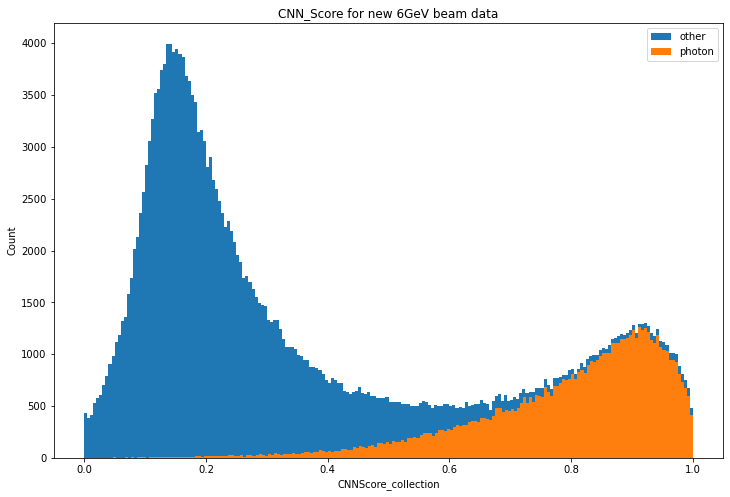

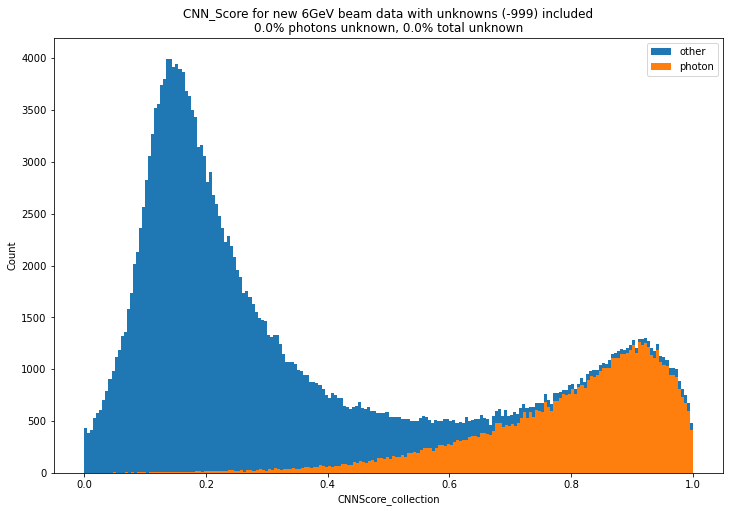

In [21]:
plotParameterDistribution(cnn_score, pdg_vals, f"CNN_Score for new 6GeV beam data", "CNNScore_collection")

Best cut found to be 0.840 with fpr: 1804.000, eff: 32957.000.


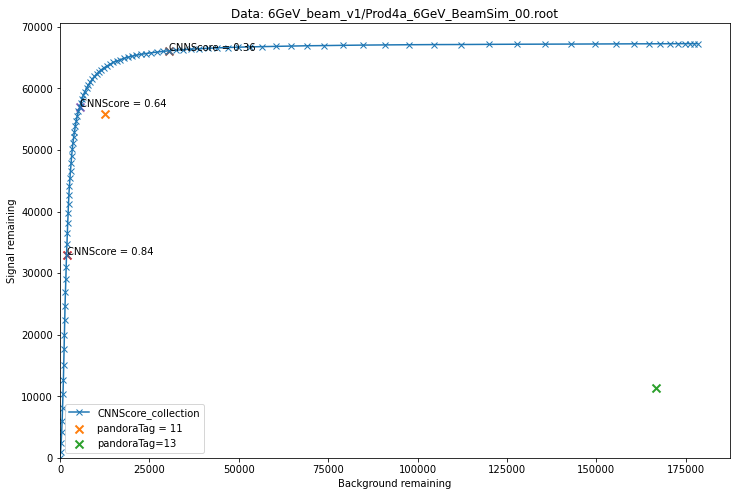

In [35]:
fig = plt.figure(figsize=(12,8))
axis = fig.add_subplot()
axis.set_title("Data: " + new_data_name)
rocCurve(
    cnn_score,
    pdg_vals,
    particle = 22, labels="CNNScore_collection", cut_high=False, ax = axis
)

axis.scatter(
    sum(np.logical_and(pandora_tag == 11, pdg_vals != 22)),
    sum(np.logical_and(pandora_tag == 11, pdg_vals == 22)),
    marker='x', label='pandoraTag = 11', lw=2, s=64, c='C1'
)
axis.scatter(
    sum(np.logical_and(pandora_tag == 13, pdg_vals != 22)),
    sum(np.logical_and(pandora_tag == 13, pdg_vals == 22)),
    marker='x', label='pandoraTag=13', lw=2, s=64, c='C2'
)

cnn_cut = 0.84
axis.scatter(
    sum(np.logical_and(np.logical_and(cnn_score > cnn_cut, cnn_score != -999), pdg_vals != 22)),
    sum(np.logical_and(np.logical_and(cnn_score > cnn_cut, cnn_score != -999), pdg_vals == 22)),
    marker='x', lw=2, s=64, c='C3'
)
axis.annotate(
    f"CNNScore = {cnn_cut}",
    (sum(np.logical_and(np.logical_and(cnn_score > cnn_cut, cnn_score != -999), pdg_vals != 22)),
    sum(np.logical_and(np.logical_and(cnn_score > cnn_cut, cnn_score != -999), pdg_vals == 22)))
)
cnn_cut = 0.64
axis.scatter(
    sum(np.logical_and(np.logical_and(cnn_score > cnn_cut, cnn_score != -999), pdg_vals != 22)),
    sum(np.logical_and(np.logical_and(cnn_score > cnn_cut, cnn_score != -999), pdg_vals == 22)),
    marker='x', lw=2, s=64, c='C4'
)
axis.annotate(
    f"CNNScore = {cnn_cut}",
    (sum(np.logical_and(np.logical_and(cnn_score > cnn_cut, cnn_score != -999), pdg_vals != 22)),
    sum(np.logical_and(np.logical_and(cnn_score > cnn_cut, cnn_score != -999), pdg_vals == 22)))
)
cnn_cut = 0.36
axis.scatter(
    sum(np.logical_and(np.logical_and(cnn_score > cnn_cut, cnn_score != -999), pdg_vals != 22)),
    sum(np.logical_and(np.logical_and(cnn_score > cnn_cut, cnn_score != -999), pdg_vals == 22)),
    marker='x', lw=2, s=64, c='C5'
)
axis.annotate(
    f"CNNScore = {cnn_cut}",
    (sum(np.logical_and(np.logical_and(cnn_score > cnn_cut, cnn_score != -999), pdg_vals != 22)),
    sum(np.logical_and(np.logical_and(cnn_score > cnn_cut, cnn_score != -999), pdg_vals == 22)))
)

axis.legend()
axis.set_xlim(0)
axis.set_ylim(0)

plt.show()

In [31]:
for c in np.arange(0,1,0.01):
    print(f"{c}:{sum(np.logical_and(np.logical_and(cnn_score > c, cnn_score != -999), pdg_vals == 22))/sum(np.logical_and(np.logical_and(cnn_score > c, cnn_score != -999), pdg_vals != 22))}")
# print(f"0.85:{sum(np.logical_and(np.logical_and(cnn_score > 0.9, cnn_score != -999), pdg_vals == 22))/sum(np.logical_and(np.logical_and(cnn_score > 0.9, cnn_score != -999), pdg_vals != 22))}")

0.0:0.375420584214491
0.01:0.37710541508556183
0.02:0.3791006930748859
0.03:0.38164201879931703
0.04:0.38488383402081316
0.05:0.38904407469738767
0.06:0.3942571448667151
0.07:0.40048588492387205
0.08:0.4084964739754484
0.09:0.41898341412354045
0.1:0.4321487566122263
0.11:0.4490004475109707
0.12:0.47015656261805155
0.13:0.495344739887802
0.14:0.5253806511147779
0.15:0.5597626330396807
0.16:0.5985467837560736
0.17:0.6415272866290739
0.18:0.6880851543833383
0.19:0.7372708086004485
0.2:0.7907432089737088
0.21:0.8469687010163321
0.22:0.9065715368785877
0.23:0.9691441147937391
0.24:1.0353737073503004
0.25:1.1068695968997384
0.26:1.1805504003393605
0.27:1.2565034069946919
0.28:1.3378665703855257
0.29:1.42192400418169
0.3:1.5136388434260775
0.31:1.606471866698865
0.32:1.712000206100577
0.33:1.8181818181818181
0.34:1.9243541364296082
0.35000000000000003:2.0432622581541025
0.36:2.166906993511175
0.37:2.2975220992552376
0.38:2.4320614067458854
0.39:2.58098936879683
0.4:2.7316555740432613
0.410000

ZeroDivisionError: division by zero

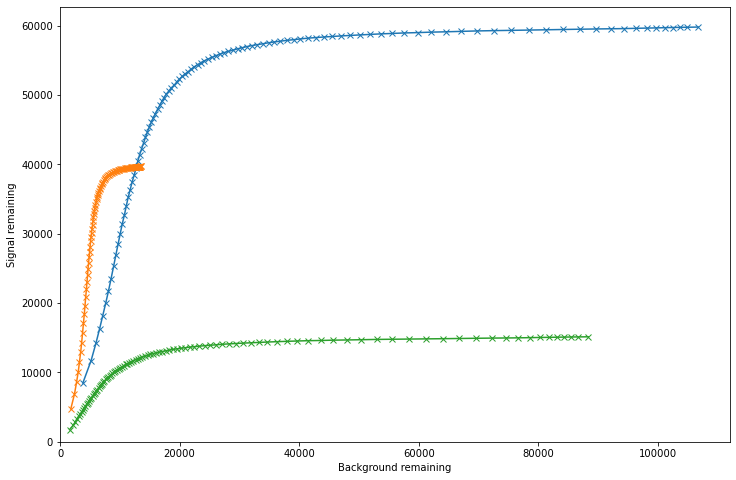

In [32]:
rocCurve(
    [cnn_score, cnn_score[pandora_tag == 11], cnn_score[pandora_tag == 13]],
    [pdg_vals, pdg_vals[pandora_tag == 11], pdg_vals[pandora_tag == 13]],
    labels=["CNNScore_collection", "CNNScore, tag=11", "CNNScore, tag=13"],
    particle = 22, cut_high=True
)


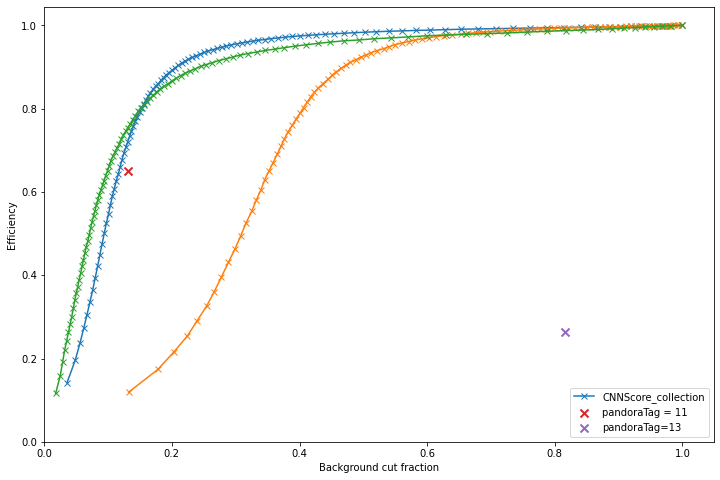

In [34]:
fig = plt.figure(figsize=(12,8))
axis = fig.add_subplot()
rocCurve(
    [cnn_score, cnn_score[pandora_tag == 11], cnn_score[pandora_tag == 13]],
    [pdg_vals, pdg_vals[pandora_tag == 11], pdg_vals[pandora_tag == 13]],
    labels=["CNNScore_collection", "CNNScore, tag=11", "CNNScore, tag=13"],
    particle = 22, cut_high=True, ax = axis, norm=True
)

axis.scatter(
    ak.num(pandora_tag[np.logical_and(pandora_tag == 11, pdg_vals != 22)], axis=0)/total_bkg,
    ak.num(pandora_tag[np.logical_and(pandora_tag == 11, pdg_vals == 22)], axis=0)/total_sig,
    marker='x', label='pandoraTag = 11', lw=2, s=64, c='C3'
)
axis.scatter(
    ak.num(pandora_tag[np.logical_and(pandora_tag == 13, pdg_vals != 22)], axis=0)/total_bkg,
    ak.num(pandora_tag[np.logical_and(pandora_tag == 13, pdg_vals == 22)], axis=0)/total_sig,
    marker='x', label='pandoraTag=13', lw=2, s=64, c='C4'
)
axis.legend()
axis.set_xlim(0)
axis.set_ylim(0)

plt.show()

Best cut found to be 1.280 with fpr: 22139.000, eff: 46072.000.
Best cut found to be 1.210 with fpr: 13013.000, eff: 40498.000.
Best cut found to be 1.010 with fpr: 22446.000, eff: 43448.000.
Best cut found to be 1.300 with fpr: 7230.000, eff: 33742.000.
Best cut found to be 1.310 with fpr: 12884.000, eff: 9679.000.


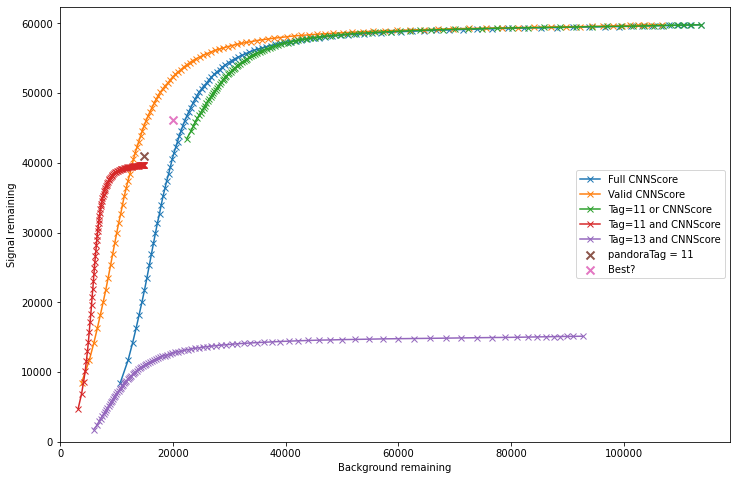

In [27]:
fig = plt.figure(figsize=(12,8))
axis = fig.add_subplot()
rocCurve(
    cnn_score_all,
    pdg_vals_all,
    particle = 22, labels="Full CNNScore", cut_high=True, ax = axis, include_unknown=True
)
rocCurve(
    cnn_score_all,
    pdg_vals_all,
    particle = 22, labels="Valid CNNScore", cut_high=True, ax = axis, include_unknown=False
)
rocCurve(
    cnn_score_all,
    pdg_vals_all,
    particle = 22, labels="Tag=11 or CNNScore", cut_high=True, ax = axis, include_unknown=True, cut_func = lambda x, m, c : np.logical_or(x[m] < c, pandora_tag_all[m] == 11)
)
rocCurve(
    cnn_score_all,
    pdg_vals_all,
    particle = 22, labels="Tag=11 and CNNScore", cut_high=True, ax = axis, include_unknown=True, cut_func = lambda x, m, c : np.logical_and(x[m] < c, pandora_tag_all[m] == 11)
)
rocCurve(
    cnn_score_all,
    pdg_vals_all,
    particle = 22, labels="Tag=13 and CNNScore", cut_high=True, ax = axis, include_unknown=True, cut_func = lambda x, m, c : np.logical_and(x[m] < c, pandora_tag_all[m] == 13)
)
axis.scatter(
    sum(np.logical_and(pandora_tag_all == 11, pdg_vals_all != 22)),
    sum(np.logical_and(pandora_tag_all == 11, pdg_vals_all == 22)),
    marker='x', label='pandoraTag = 11', lw=2, s=64, c='C5'
)
axis.scatter(
    sum( np.logical_or(np.logical_and(np.logical_and(cnn_score_all < 1.3, pandora_tag_all == 11), pdg_vals_all != 22), np.logical_and(np.logical_and(cnn_score_all < 1.31, pandora_tag_all == 13), pdg_vals_all != 22)) ),
    sum( np.logical_or(np.logical_and(np.logical_and(cnn_score_all < 1.3, pandora_tag_all == 11), pdg_vals_all == 22), np.logical_and(np.logical_and(cnn_score_all < 1.31, pandora_tag_all == 13), pdg_vals_all == 22)) ),
    marker='x', label='Best?', lw=2, s=64, c='C6'
)

axis.legend()
axis.set_xlim(0)
axis.set_ylim(0)
# axis.set_xlim(10000)
# axis.set_ylim(10000)
# axis.set_xscale('log')
# axis.set_yscale('log')

plt.show()

Best cut found to be 1.410 with fpr: 0.240, eff: 0.836.
Best cut found to be 1.420 with fpr: 0.196, eff: 0.841.
Best cut found to be 1.270 with fpr: 0.262, eff: 0.836.
Best cut found to be 1.680 with fpr: 0.109, eff: 0.626.
Best cut found to be 1.580 with fpr: 0.205, eff: 0.211.


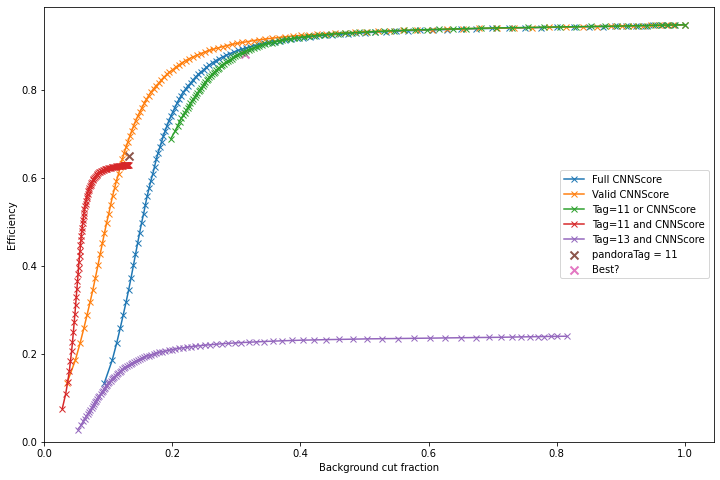

In [29]:
fig = plt.figure(figsize=(12,8))
axis = fig.add_subplot()
rocCurve(
    cnn_score_all,
    pdg_vals_all,
    particle = 22, labels="Full CNNScore", cut_high=True, ax = axis, include_unknown=True, norm=True
)
rocCurve(
    cnn_score_all,
    pdg_vals_all,
    particle = 22, labels="Valid CNNScore", cut_high=True, ax = axis, include_unknown=False, norm=True
)
rocCurve(
    cnn_score_all,
    pdg_vals_all,
    particle = 22, labels="Tag=11 or CNNScore", cut_high=True, ax = axis, include_unknown=True, cut_func = lambda x, m, c : np.logical_or(x[m] < c, pandora_tag_all[m] == 11), norm=True
)
rocCurve(
    cnn_score_all,
    pdg_vals_all,
    particle = 22, labels="Tag=11 and CNNScore", cut_high=True, ax = axis, include_unknown=True, cut_func = lambda x, m, c : np.logical_and(x[m] < c, pandora_tag_all[m] == 11), norm=True
)
rocCurve(
    cnn_score_all,
    pdg_vals_all,
    particle = 22, labels="Tag=13 and CNNScore", cut_high=True, ax = axis, include_unknown=True, cut_func = lambda x, m, c : np.logical_and(x[m] < c, pandora_tag_all[m] == 13), norm=True
)
axis.scatter(
    sum(np.logical_and(pandora_tag_all == 11, pdg_vals_all != 22))/total_bkg_all,
    sum(np.logical_and(pandora_tag_all == 11, pdg_vals_all == 22))/total_sig_all,
    marker='x', label='pandoraTag = 11', lw=2, s=64, c='C5'
)
axis.scatter(
    sum( np.logical_or(np.logical_and(np.logical_and(cnn_score_all < 1.68, pandora_tag_all == 11), pdg_vals_all != 22), np.logical_and(np.logical_and(cnn_score_all < 1.58, pandora_tag_all == 13), pdg_vals_all != 22)) ) /total_bkg_all,
    sum( np.logical_or(np.logical_and(np.logical_and(cnn_score_all < 1.68, pandora_tag_all == 11), pdg_vals_all == 22), np.logical_and(np.logical_and(cnn_score_all < 1.58, pandora_tag_all == 13), pdg_vals_all == 22)) ) /total_sig_all,
    marker='x', label='Best?', lw=2, s=64, c='C6'
)

axis.legend()
axis.set_xlim(0)
axis.set_ylim(0)
# axis.set_xlim(10000)
# axis.set_ylim(10000)
# axis.set_xscale('log')
# axis.set_yscale('log')

plt.show()

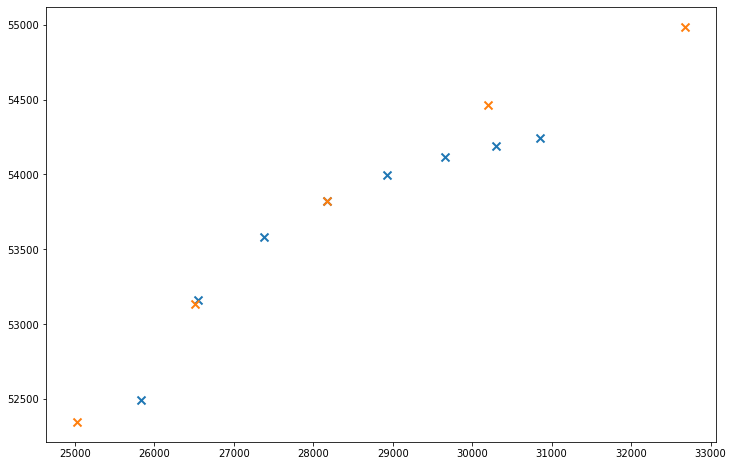

In [42]:
plt.figure(figsize=(12,8))
plt.scatter(
    [ak.num(pandora_tag[np.logical_or( np.logical_and(np.logical_and(pandora_tag == 13, cnn_score<1.45), pdg_vals != 22), np.logical_and(np.logical_and(pandora_tag == 11, cnn_score<cut), pdg_vals != 22) )], axis=0) for cut in np.arange(1.45,1.8, 0.05)],
    [ak.num(pandora_tag[np.logical_or( np.logical_and(np.logical_and(pandora_tag == 13, cnn_score<1.45), pdg_vals == 22), np.logical_and(np.logical_and(pandora_tag == 11, cnn_score<cut), pdg_vals == 22) )], axis=0) for cut in np.arange(1.45,1.8, 0.05)],
    marker='x', label='Cut on 11', lw=2, s=64, c='C0'
)
plt.scatter(
    [ak.num(pandora_tag[np.logical_or( np.logical_and(np.logical_and(pandora_tag == 13, cnn_score<cut), pdg_vals != 22), np.logical_and(np.logical_and(pandora_tag == 11, cnn_score<1.6), pdg_vals != 22) )], axis=0) for cut in np.arange(1.35,1.6, 0.05)],
    [ak.num(pandora_tag[np.logical_or( np.logical_and(np.logical_and(pandora_tag == 13, cnn_score<cut), pdg_vals == 22), np.logical_and(np.logical_and(pandora_tag == 11, cnn_score<1.6), pdg_vals == 22) )], axis=0) for cut in np.arange(1.35,1.6, 0.05)],
    marker='x', label='Cut on 13', lw=2, s=64, c='C1'
)
plt.scatter(
    [ak.num(pandora_tag[np.logical_or( np.logical_and(np.logical_and(pandora_tag == 13, cnn_score<cut), pdg_vals != 22), np.logical_and(np.logical_and(pandora_tag == 11, cnn_score<1.6), pdg_vals != 22) )], axis=0) for cut in np.arange(1.35,1.6, 0.05)],
    [ak.num(pandora_tag[np.logical_or( np.logical_and(np.logical_and(pandora_tag == 13, cnn_score<cut), pdg_vals == 22), np.logical_and(np.logical_and(pandora_tag == 11, cnn_score<1.6), pdg_vals == 22) )], axis=0) for cut in np.arange(1.35,1.6, 0.05)],
    marker='x', label='Cut on 13', lw=2, s=64, c='C1'
)

plt.show()